# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [80]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array, check_X_y
from typing import Dict, List, Set, Tuple, Optional
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin, clone
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ id      ┆ date       ┆ client_id ┆ card_id ┆ … ┆ credit_lim ┆ acct_open_ ┆ year_pin_ ┆ card_on_d │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ it         ┆ date       ┆ last_chan ┆ ark_web   │
│ i64     ┆ datetime[n ┆ i64       ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ged       ┆ ---       │
│         ┆ s]         ┆           ┆         ┆   ┆ f64        ┆ str        ┆ ---       ┆ str       │
│         ┆            ┆           ┆         ┆   ┆            ┆            ┆ i64       ┆           │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7475328 ┆ 2010-01-01 ┆ 561       ┆ 4575    ┆ … ┆ 9100.0     ┆ 09/2005    ┆ 2015      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475329 ┆ 2010-01-01 ┆ 1129      ┆ 102     ┆ … ┆ 14802.0    ┆ 01/2006    ┆ 2008      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475332 ┆ 2010-01-01 ┆ 848       ┆ 3915    ┆ … ┆ 19113.0    ┆ 07/2009    ┆ 2014      ┆ No        │
│         ┆ 00:06:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475333 ┆ 2010-01-01 ┆ 1807      ┆ 165     ┆ … ┆ 89.0       ┆ 01/2008    ┆ 2015      ┆ No        │
│         ┆ 00:07:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475335 ┆ 2010-01-01 ┆ 1684      ┆ 2140    ┆ … ┆ 46.0       ┆ 03/2007    ┆ 2012      ┆ No        │
│         ┆ 00:14:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

### **Análise e Documentação Corrigida do Processo de Feature Engineering**

O script transforma dados transacionais brutos em um conjunto de features agregadas por janelas de tempo, prontas para serem usadas em modelos de detecção de fraude. O processo pode ser dividido em três etapas principais: tratamento de variáveis numéricas, categóricas e seleção final de features.

---

### ## 1. Agregação e Features Numéricas

As features numéricas são criadas agrupando os dados por uma janela de tempo (`date_window`) e aplicando as seguintes operações:

#### **Contagens e Razões**
São calculadas contagens e razões para entender o volume e a distribuição das transações em cada janela:
* `frauds`: Contagem total de fraudes (soma da coluna `target`).
* `transaction_per_client`: Média de transações por cliente único na janela.
* `transaction_per_merchant`: Média de transações por comerciante único na janela.

#### **Estatísticas de Comportamento**
Para um conjunto de colunas numéricas, são calculadas estatísticas para capturar a distribuição dos valores dentro da janela. Algumas dessas colunas são **normalizadas por um fator de escala** para manter os valores em uma ordem de magnitude similar.

* **Colunas com Fator de Escala:**
    * `amount` / 1.000
    * `per_capita_income` / 1.000
    * `total_debt` / 10.000
    * `credit_score` / 100
    * `credit_limit` / 10.000
* **Colunas Sem Fator de Escala:**
    * `current_age`
    * `num_credit_cards`

* **Estatísticas Geradas para as Colunas Acima:**
    * **Média (`mean_`):** Valor médio da feature na janela.
    * **Desvio Padrão (`std_`):** Dispersão dos valores da feature na janela.
    * **Mínimo (`min_`) e Máximo (`max_`):** O script calcula esses valores, mas as colunas `min_amount` e `max_amount` são **removidas** ao final desta etapa por serem consideradas menos informativas ou redundantes.

---

### ## 2. Features Categóricas (`city`, `country`, `description`)

O tratamento de variáveis categóricas é mais complexo e visa transformar categorias (como cidades) em representações numéricas que capturem seu risco de fraude. O fluxo é o seguinte:

1.  **Cálculo da Razão de Risco:** Para cada valor único de uma categoria (ex: para cada cidade), calcula-se a razão entre a porcentagem de transações fraudulentas e a porcentagem de transações não fraudulentas. Isso cria um "score de risco" para cada cidade.

2.  **Clusterização (KMeans):** As cidades são agrupadas (`clusterizadas`) em um número fixo de grupos (por padrão, 3) com base em seu "score de risco". Cidades com perfis de fraude semelhantes ficam no mesmo cluster.

3.  **Criação de Dummies:** Os clusters são transformados em colunas dummy (ex: `target_city_0`, `target_city_1`, `target_city_2`). Cada transação recebe o valor 1 na coluna do cluster correspondente à sua cidade e 0 nas outras.

4.  **Agregação por Janela (Proporção):** Finalmente, para cada janela de tempo, o script calcula a **proporção** de transações que pertencem a cada um dos clusters. Por exemplo, uma janela pode ter 70% de suas transações em cidades de "baixo risco" (cluster 0), 20% em cidades de "médio risco" (cluster 1) e 10% em cidades de "alto risco" (cluster 2).

O fluxo completo pode ser resumido como: **Razão de Risco → Clusterização → Variáveis Dummy → Proporção por Janela**.

---

### ## 3. Seleção de Features (Pós-processamento)

Após a criação de todas as features numéricas e categóricas, é executada uma etapa final de seleção para reduzir a redundância e o ruído:

* **Remoção de Features Altamente Correlacionadas:** O script calcula a matriz de correlação entre todas as features geradas. Se duas features tiverem uma correlação maior que um limiar (definido como **0.75**), aquela com a **menor variância** é removida. Isso ajuda a evitar problemas de multicolinearidade no modelo final.

In [169]:
class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    def __init__(self, df: pl.DataFrame, method_corr='pearson', save_features_corr=None):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()
        self.method_corr = method_corr
        self.save_features_corr = save_features_corr

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns
            for column, scale_factor in self.SCALE_FACTORS.items():
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, scale_factor)
                    )

            # Add statistics for columns without scaling
            for column in ['current_age', 'num_credit_cards']:
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, 1.0)
                    )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
                # .drop([
                #     "transactions", "total_amount", "unique_clients", "unique_merchants"
                # ] + [f"min_{col}" for col in ["amount"] if col in df.columns]
                #   + [f"max_{col}" for col in ["amount"] if col in df.columns])
                .drop_nulls()
            )

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr(numeric_only=True, method=self.method_corr)

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str, remove_high_correlation=True) -> pd.DataFrame:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')

        Returns:
            pandas DataFrame with engineered features ready for modeling

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Convert to pandas for correlation analysis
            df_pandas = df_with_categories.to_pandas()

            # Remove highly correlated features
            removed_columns = ['date_window']
            if self.save_features_corr:
              if isinstance(self.save_features_corr, str):
                removed_columns.append(self.save_features_corr)
              elif isinstance(self.save_features_corr, list):
                removed_columns.extend(self.save_features_corr)
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=removed_columns, errors='ignore')
            )

            if columns_to_remove and remove_high_correlation:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")

            return df_pandas.sort_values('date_window')

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'scale_factors': self.SCALE_FACTORS,
        }

### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [149]:
class BaselineCoutingModel:
  def __init__(self, df: pd.DataFrame, window: str):
    self.df = df
    self.models= []
    self.window = window
    # Adicione um mapeamento de nomes para facilitar a plotagem
    self.model_name_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial': self._plot_neg_binomial_dist, # Assumindo que Binomial na verdade é Binomial Negativa
        'Zip': self._plot_zip_dist,
        'Zimb': self._plot_zinb_dist,
    }

  # --- MÉTODOS DE TREINO (sem alterações) ---
  def train_poisson(self):
    return smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson()).fit()

  def train_binomial(self): # Este método treina um Binomial Negativo
    return sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df).fit(disp=False, maxiter=1000)

  def train_zip(self):
    return sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train_zimb(self):
    return sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train(self):
    # Ajustei os nomes para corresponder à implementação e ao gráfico desejado
    models = {'Poisson': self.train_poisson,
              'Binomial Negativa': self.train_binomial,
              'ZIP': self.train_zip,
              'ZINB': self.train_zimb}

    for model_name, action in models.items():
      print(f'Training BASELINE {model_name} with window {self.window}')
      try:
        model = action()
        self.models.append(dict(name=model_name, model=model))
      except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
    print('Baseline Models Trained')

  # --- MÉTODO DE RELATÓRIO (sem alterações) ---
  def get_report(self) -> pd.DataFrame:
    # ... (código do get_report como na resposta anterior)
    metrics = []
    for model in self.models:
      model_name = model.get('name')
      model_trained = model.get('model')
      rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
      outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
      metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
      if hasattr(model_trained, 'prsquared'):
        metric['PseudoR2'] = model_trained.prsquared
      elif hasattr(model_trained, 'pseudo_rsquared'):
         metric['PseudoR2'] = model_trained.pseudo_rsquared()
      else:
         metric['PseudoR2'] = 0.0
      metric['RMSE_Pearson'] = rmse_resid
      metric['Outliers'] = outliers
      metrics.append(metric)
    return pd.DataFrame(metrics)

  # --- NOVO MÉTODO DE PLOTAGEM ---
  def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
    """
    Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
    """
    if not self.models:
        print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
        return

    y = self.df[target_col]
    max_fraudes = int(y.max())
    bins = np.arange(0, max_fraudes + 2)
    total_obs = len(y)

    plt.style.use('seaborn-v0_8-whitegrid') # Estilo similar ao da imagem
    plt.figure(figsize=fig_size) # Tamanho maior para melhor visualização

    # 1. Plota a distribuição observada
    ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

    # 2. Plota a curva de cada modelo treinado
    plot_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial Negativa': self._plot_neg_binomial_dist,
        'ZIP': self._plot_zip_dist,
        'ZINB': self._plot_zinb_dist
    }

    for model_info in self.models:
        model_name = model_info['name']
        model_trained = model_info['model']

        if model_name in plot_map:
            plot_map[model_name](ax, model_trained, bins, total_obs)

    # 3. Finaliza o gráfico
    ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
    ax.set_xlabel('Fraudes', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
    plt.tight_layout()
    plt.show()

  # --- MÉTODOS AUXILIARES PARA PLOTAGEM ---
  def _plot_poisson_dist(self, ax, model, bins, total_obs):
    lambda_poisson = np.exp(model.params['Intercept'])
    poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
    ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

  def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
    mu_negbin = np.exp(model.params['Intercept'])
    alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None)) # Compatibilidade
    if alpha_negbin is None: return

    n = 1 / alpha_negbin
    p = n / (n + mu_negbin)
    negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

  def _plot_zip_dist(self, ax, model, bins, total_obs):
    lambda_zip = np.exp(model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

    zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
    zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
    zip_freq = zip_pmf * total_obs
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

  def _plot_zinb_dist(self, ax, model, bins, total_obs):
    mu_zinb = np.exp(model.params['Intercept'])
    alpha_zinb = model.params['alpha']
    pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

    n = 1 / alpha_zinb
    p = n / (n + mu_zinb)

    zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
    zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
    zinb_freq = zinb_pmf * total_obs
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [150]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [151]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de auto-correlação

In [152]:
def validar_autocorrelacao_ljung_box(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("✅ Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("✅ Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")


### Gráficos Auxiliares

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [153]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Plot dos modelos com base no llf

In [154]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [155]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Gráfico ACF
  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  # Gráfico PACF
  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [156]:
from typing import List, Optional, Dict, Tuple
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y
import warnings


class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor stepwise simplificado para modelos Zero-Inflated com validação de convergência.
    """

    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-6,
                 convergence_patience=3,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 1.1 Verifica se existe ao menos uma feature diferente de constante e alpha
            if hasattr(result, 'params'):
                non_const_alpha_params = [param for param in result.params.index.to_list() if 'const' not in param and 'alpha' not in param]
                if not non_const_alpha_params:
                    if self.verbose:
                        print("   No non-constant, non-alpha features found")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

In [157]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


#### RandomFeatureSelector

In [158]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

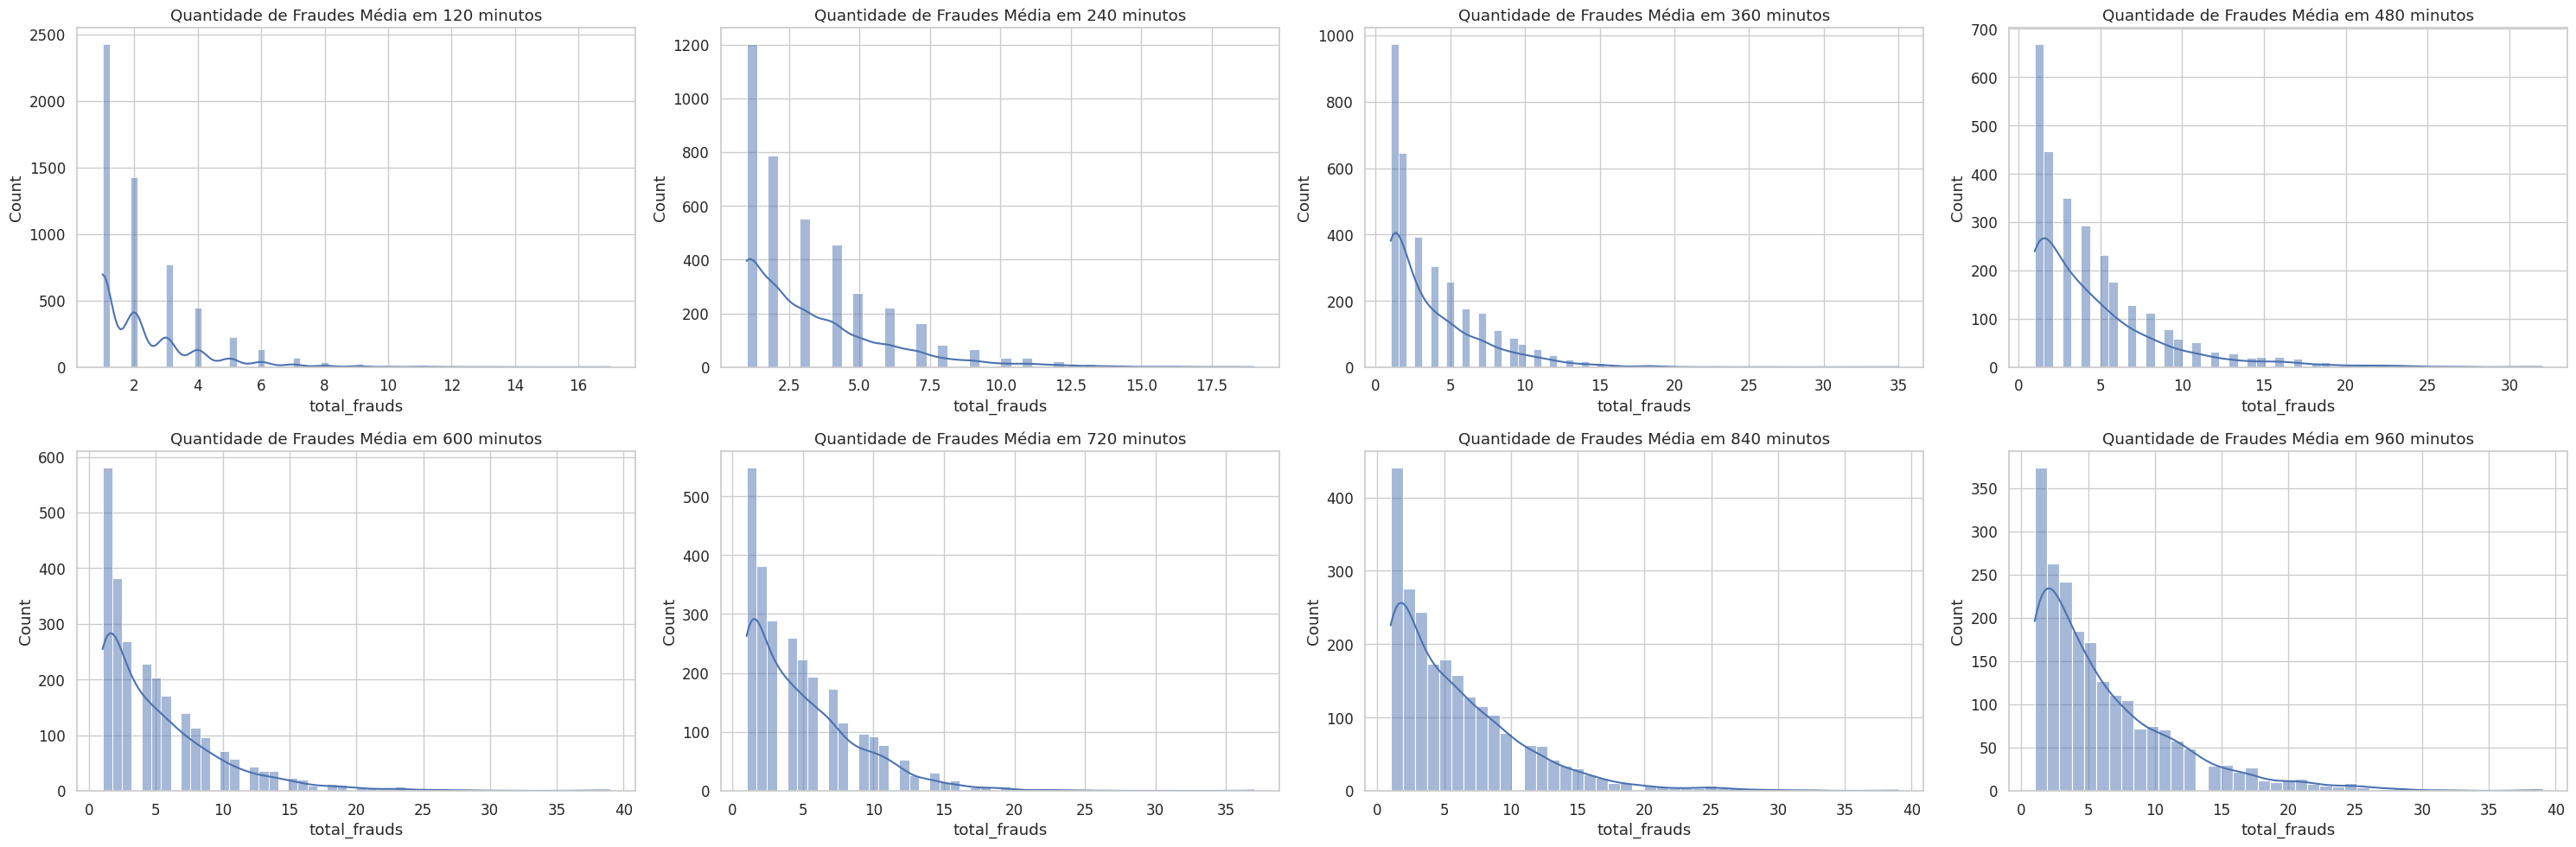

In [159]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [160]:
window_data_builder = WindowDataBuilder(df)

In [161]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):
  df_train = window_data_builder.build(f'{minute}m', False)

  builder = BaselineCoutingModel(df_train, f'{minute}m')
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/8 [00:00<?, ?it/s]

Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m
Baseline Models Trained
Training BASELINE Poisson with window 240m
Training BASELINE Binomial Negativa with window 240m
Training BASELINE ZIP with window 240m
Training BASELINE ZINB with window 240m
Baseline Models Trained
Training BASELINE Poisson with window 360m
Training BASELINE Binomial Negativa with window 360m
Training BASELINE ZIP with window 360m
Training BASELINE ZINB with window 360m
Baseline Models Trained
Training BASELINE Poisson with window 480m
Training BASELINE Binomial Negativa with window 480m
Training BASELINE ZIP with window 480m
Training BASELINE ZINB with window 480m
Baseline Models Trained
Training BASELINE Poisson with window 600m
Training BASELINE Binomial Negativa with window 600m
Training BASELINE ZIP with window 600m
Training BASELINE ZINB with window 600m
Baseline Models Trained
Train

In [162]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=True)
df_report.reset_index(drop=True, inplace=True)
df_report

window         model_name           LLF            BIC           AIC  \
0    120m            Poisson -36273.604984 -401387.909697  72549.209969   
1    240m            Poisson -30830.871549 -164337.621400  61663.743097   
2    360m            Poisson -27657.000514  -91942.236354  55316.001029   
3    120m                ZIP -26062.748669   52146.838596  52129.497339   
4    480m            Poisson -26019.234583  -56528.888767  52040.469165   
5    120m  Binomial Negativa -25576.987256   51175.315768  51157.974512   
6    600m            Poisson -24092.703356  -37895.525961  48187.406711   
7    840m            Poisson -20865.122440  -19295.304037  41732.244881   
8    720m            Poisson -20782.606047  -30500.028095  41567.212094   
9    960m            Poisson -19912.276693  -13436.164987  39826.553386   
10   240m                ZIP -19058.367792   38136.690639  38120.735584   
11   240m  Binomial Negativa -18324.543120   36669.041295  36653.086239   
12   360m                ZIP -16724.535614   33468.215492  33453.071228   
13   360m  Binomial Negativa -15277.310548   30573.765361  30558.621096   
14   360m               ZINB -15180.577138   30389.870673  30367.154276   
15   480m                ZIP -14827.949902   29674.468844  29659.899805   
16   600m                ZIP -13612.656184   27243.435585  27229.312368   
17   480m  Binomial Negativa -13002.103261   26022.775562  26008.206522   
18   480m               ZINB -12888.073066   25803.999691  25782.146132   
19   720m                ZIP -12557.508700   25132.776067  25119.017400   
20   840m                ZIP -11871.800911   23761.052512  23747.601822   
21   600m  Binomial Negativa -11720.130967   23458.385151  23444.261934   
22   960m                ZIP -11438.067262   22893.318011  22880.134524   
23   720m  Binomial Negativa -11391.654331   22801.067328  22787.308662   
24   720m               ZINB -11214.393221   22455.424442  22434.786443   
25   840m  Binomial Negativa -10103.771434   20224.993559  20211.542869   
26   840m               ZINB  -9967.425454   19961.026943  19940.850908   
27   960m  Binomial Negativa  -9456.677230   18930.537949  18917.354461   
28   960m               ZINB  -9331.161139   18688.097510  18668.322278   
29   120m               ZINB           NaN            NaN           NaN   
30   240m               ZINB           NaN            NaN           NaN   
31   600m               ZINB           NaN            NaN           NaN   

    Converged      PseudoR2  RMSE_Pearson  Outliers  
0        True  0.000000e+00      1.820327      3183  
1        True  0.000000e+00      2.171882      1940  
2        True  0.000000e+00      2.417245      1736  
3        True -3.681522e-10      1.113878      1756  
4        True  0.000000e+00      2.703015      1328  
5        True  5.846101e-11      0.925697      1756  
6        True  8.881784e-16      2.777668      1309  
7        True  0.000000e+00      2.817431      1100  
8        True  0.000000e+00      2.496118      1148  
9        True -1.332268e-15      2.912284       868  
10       True  7.853129e-11      1.156509      1389  
11       True  9.329915e-11      0.857847       934  
12       True  8.681988e-11      1.233598      1039  
13       True  8.394330e-11      0.867140       605  
14       True -1.153744e-10      0.981012       782  
15       True  2.431044e-11      1.295223       802  
16       True  5.071754e-11      1.304707       706  
17       True  1.278904e-10      0.859201       383  
18       True  8.356305e-11      0.997480       496  
19       True  2.007960e-11      1.238186       559  
20       True -1.043610e-13      1.307395       519  
21       True  9.572165e-11      0.839992       356  
22       True -3.337508e-11      1.342494       453  
23       True  1.536576e-10      0.812383       253  
24       True  4.974909e-11      0.975133       443  
25       True  1.500922e-11      0.811507       212  
26       True -2.474161e-10      0.974390       336  
27       True  

In [163]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

window  count           llf
0   960m      4 -10447.372246
1   840m      4 -10987.786173
2   720m      4 -11974.581516
3   480m      4 -13915.026582
4   360m      4 -16000.923081

### Seleção da melhor janela de tempo

In [164]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

window         model_name           LLF           BIC           AIC  \
0   960m            Poisson -19912.276693 -13436.164987  39826.553386   
1   960m  Binomial Negativa  -9456.677230  18930.537949  18917.354461   
2   960m                ZIP -11438.067262  22893.318011  22880.134524   
3   960m               ZINB  -9331.161139  18688.097510  18668.322278   

   Converged      PseudoR2  RMSE_Pearson  Outliers  
0       True -1.332268e-15      2.912284       868  
1       True  7.036938e-11      0.817686       200  
2       True -3.337508e-11      1.342494       453  
3       True -4.173122e-10      0.978726       307

#### Visualização da distribuição observada dos eventos X modelo dummy

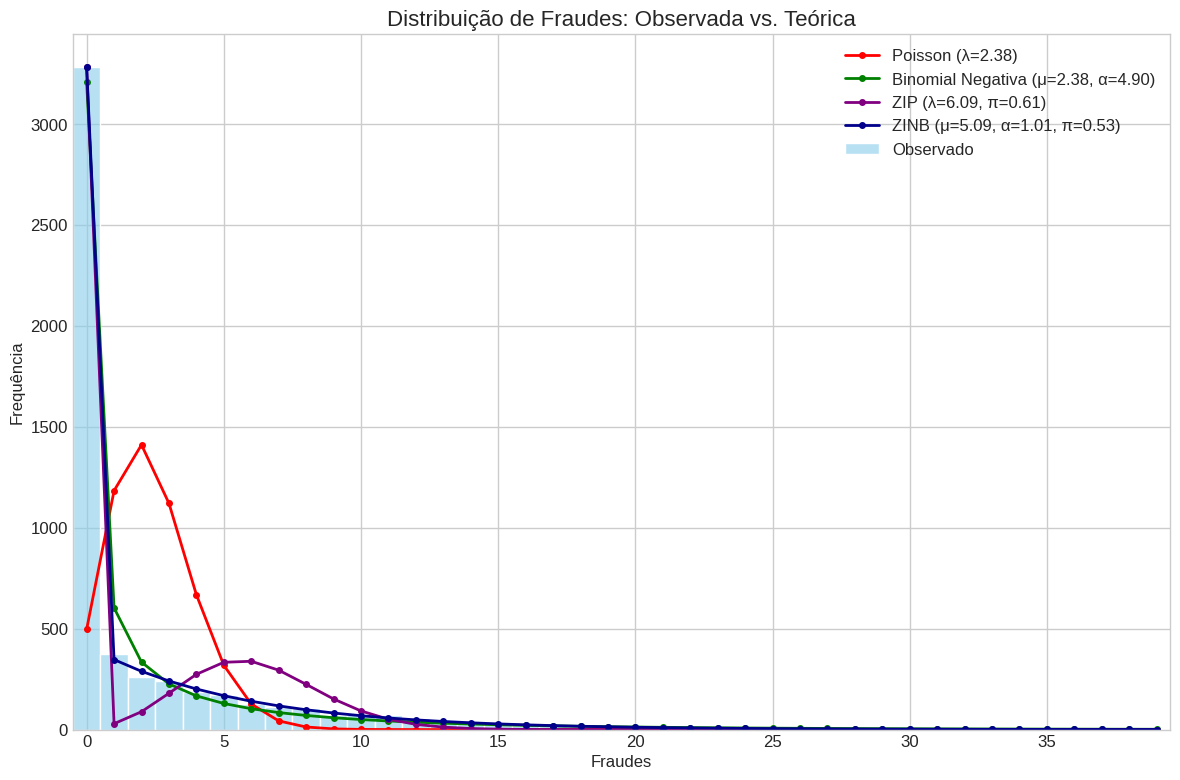

In [165]:
selected_builder.plot_theoretical_distributions()

#### Correlação dos dados no dataframe da janela selecionada

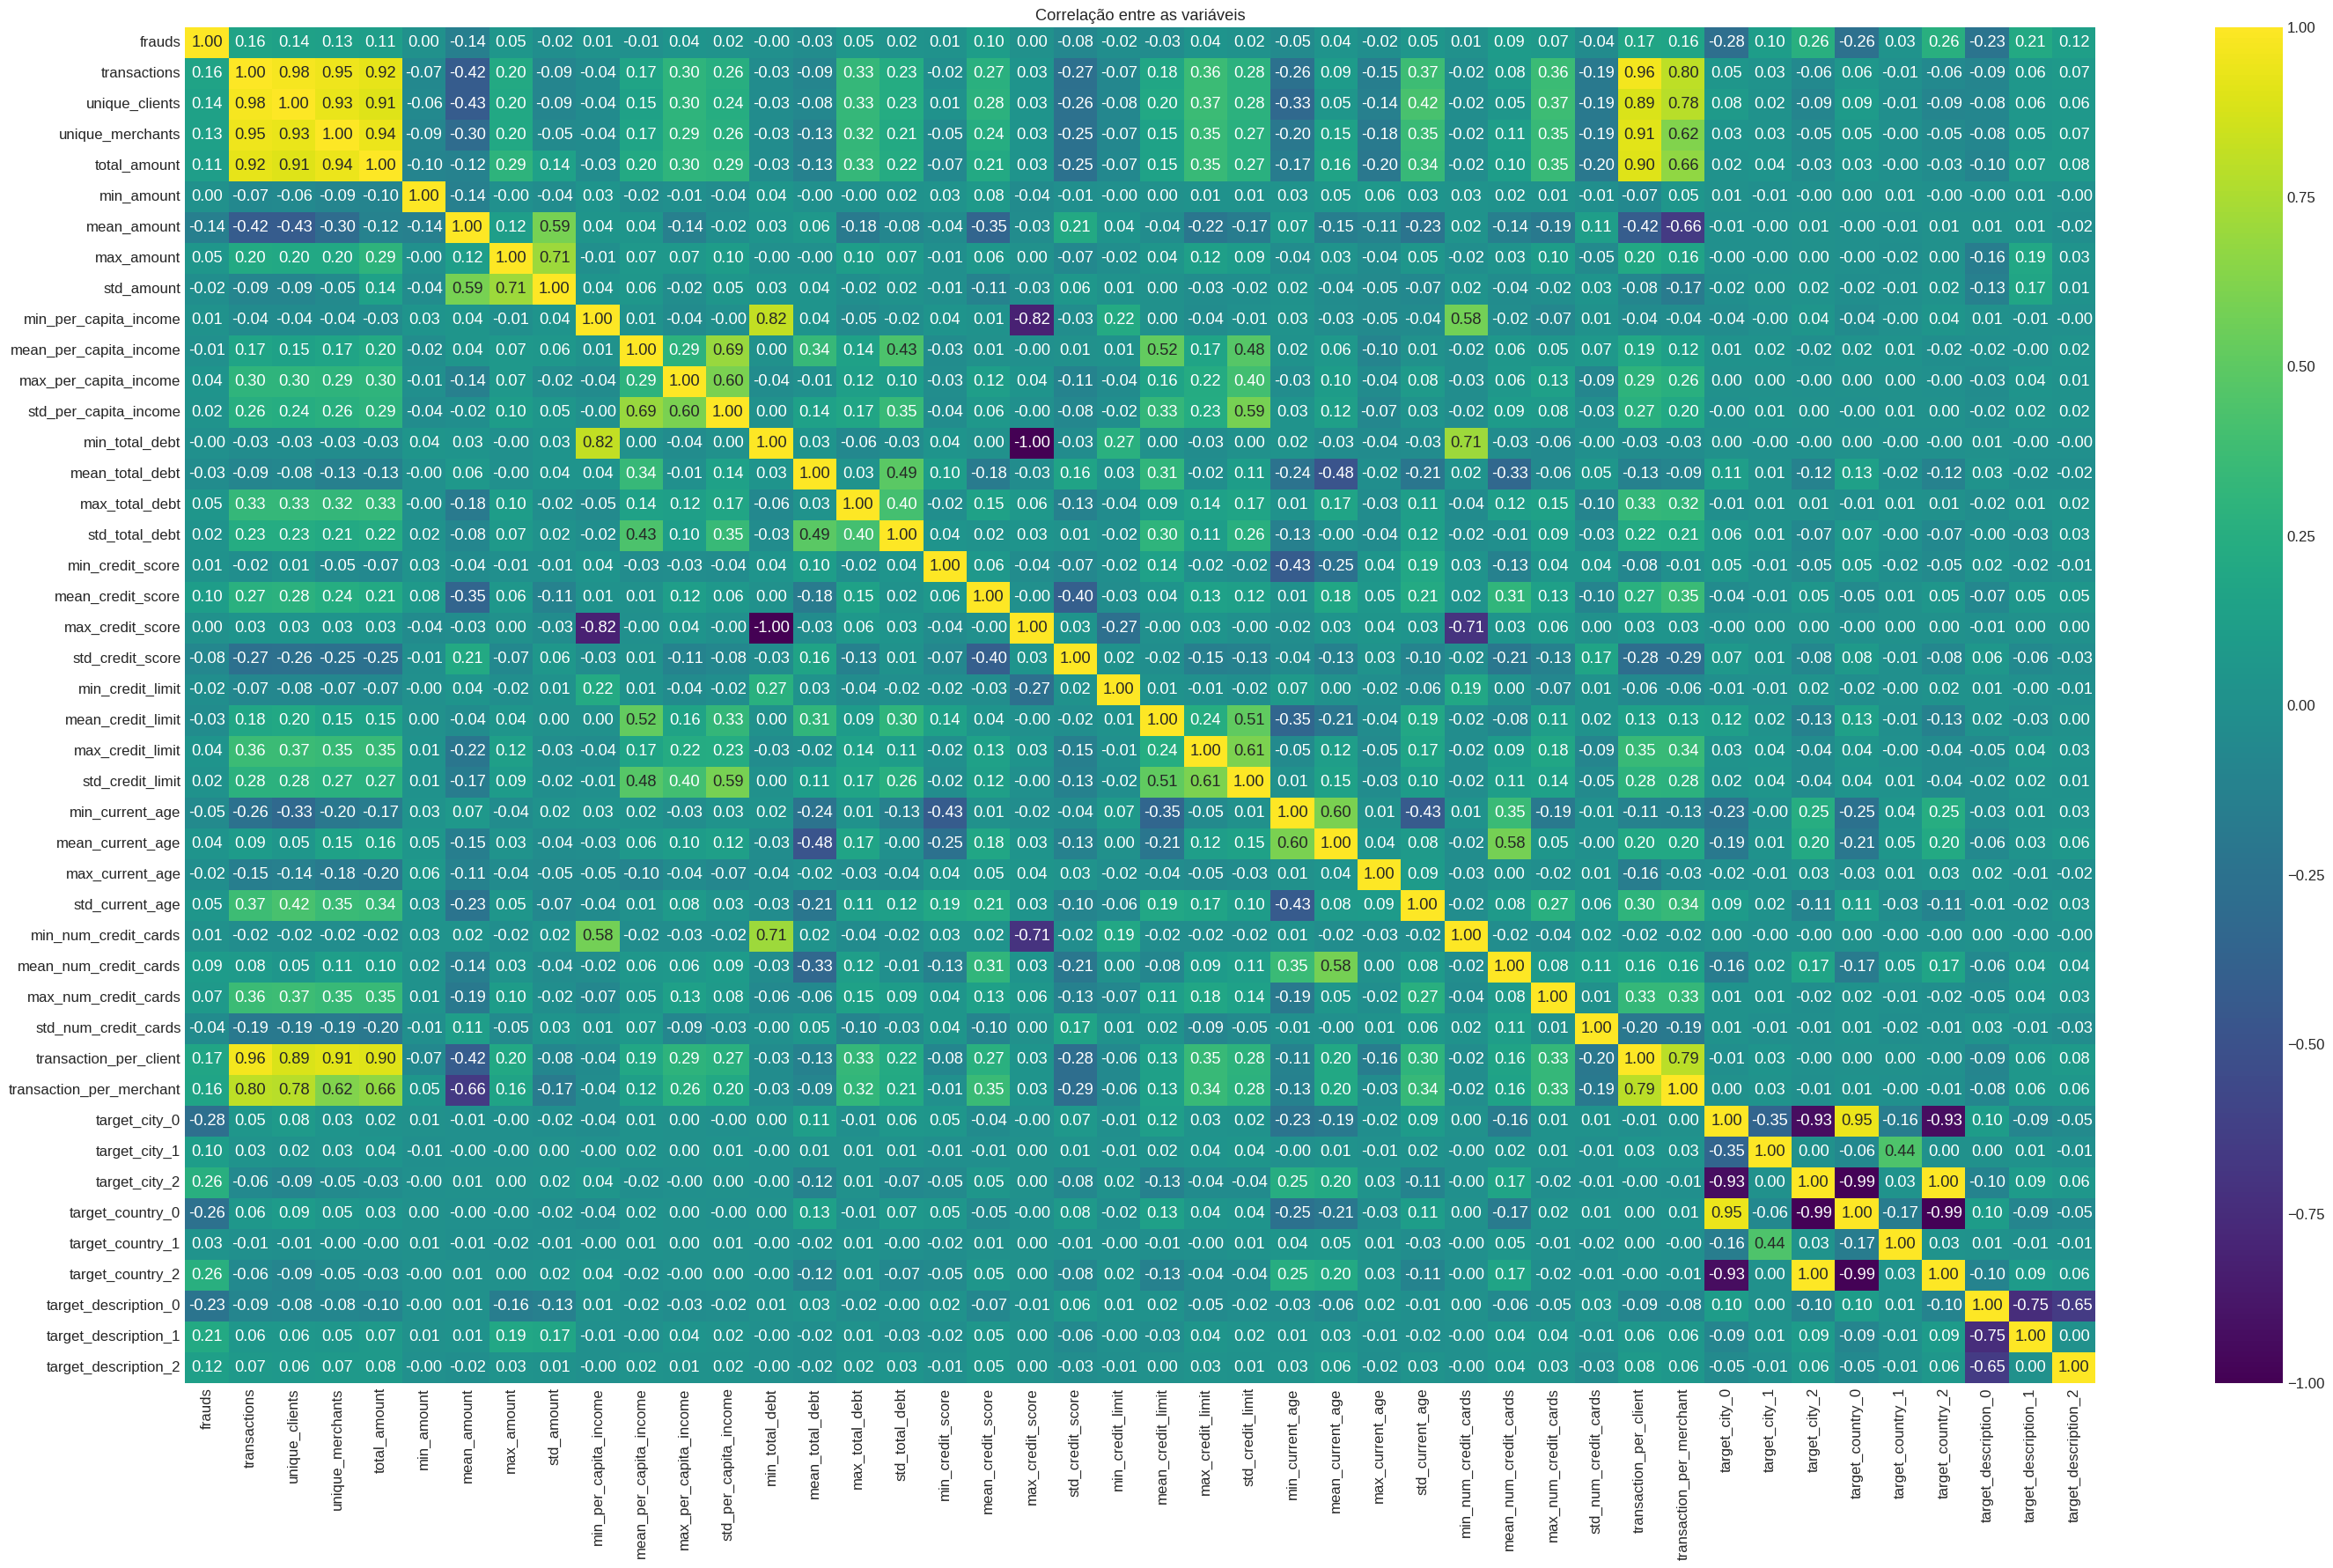

In [168]:
corr = selected_builder.df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

#### Correlação do dataframe após removação de variaveis com alta correlação

In [25]:
df_train = window_data_builder.build(selected_builder.window, True)
selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
builder.train()

Removed 10 highly correlated features
Training BASELINE Poisson with window 960m
Training BASELINE Binomial Negativa with window 960m
Training BASELINE ZIP with window 960m
Training BASELINE ZINB with window 960m
Baseline Models Trained


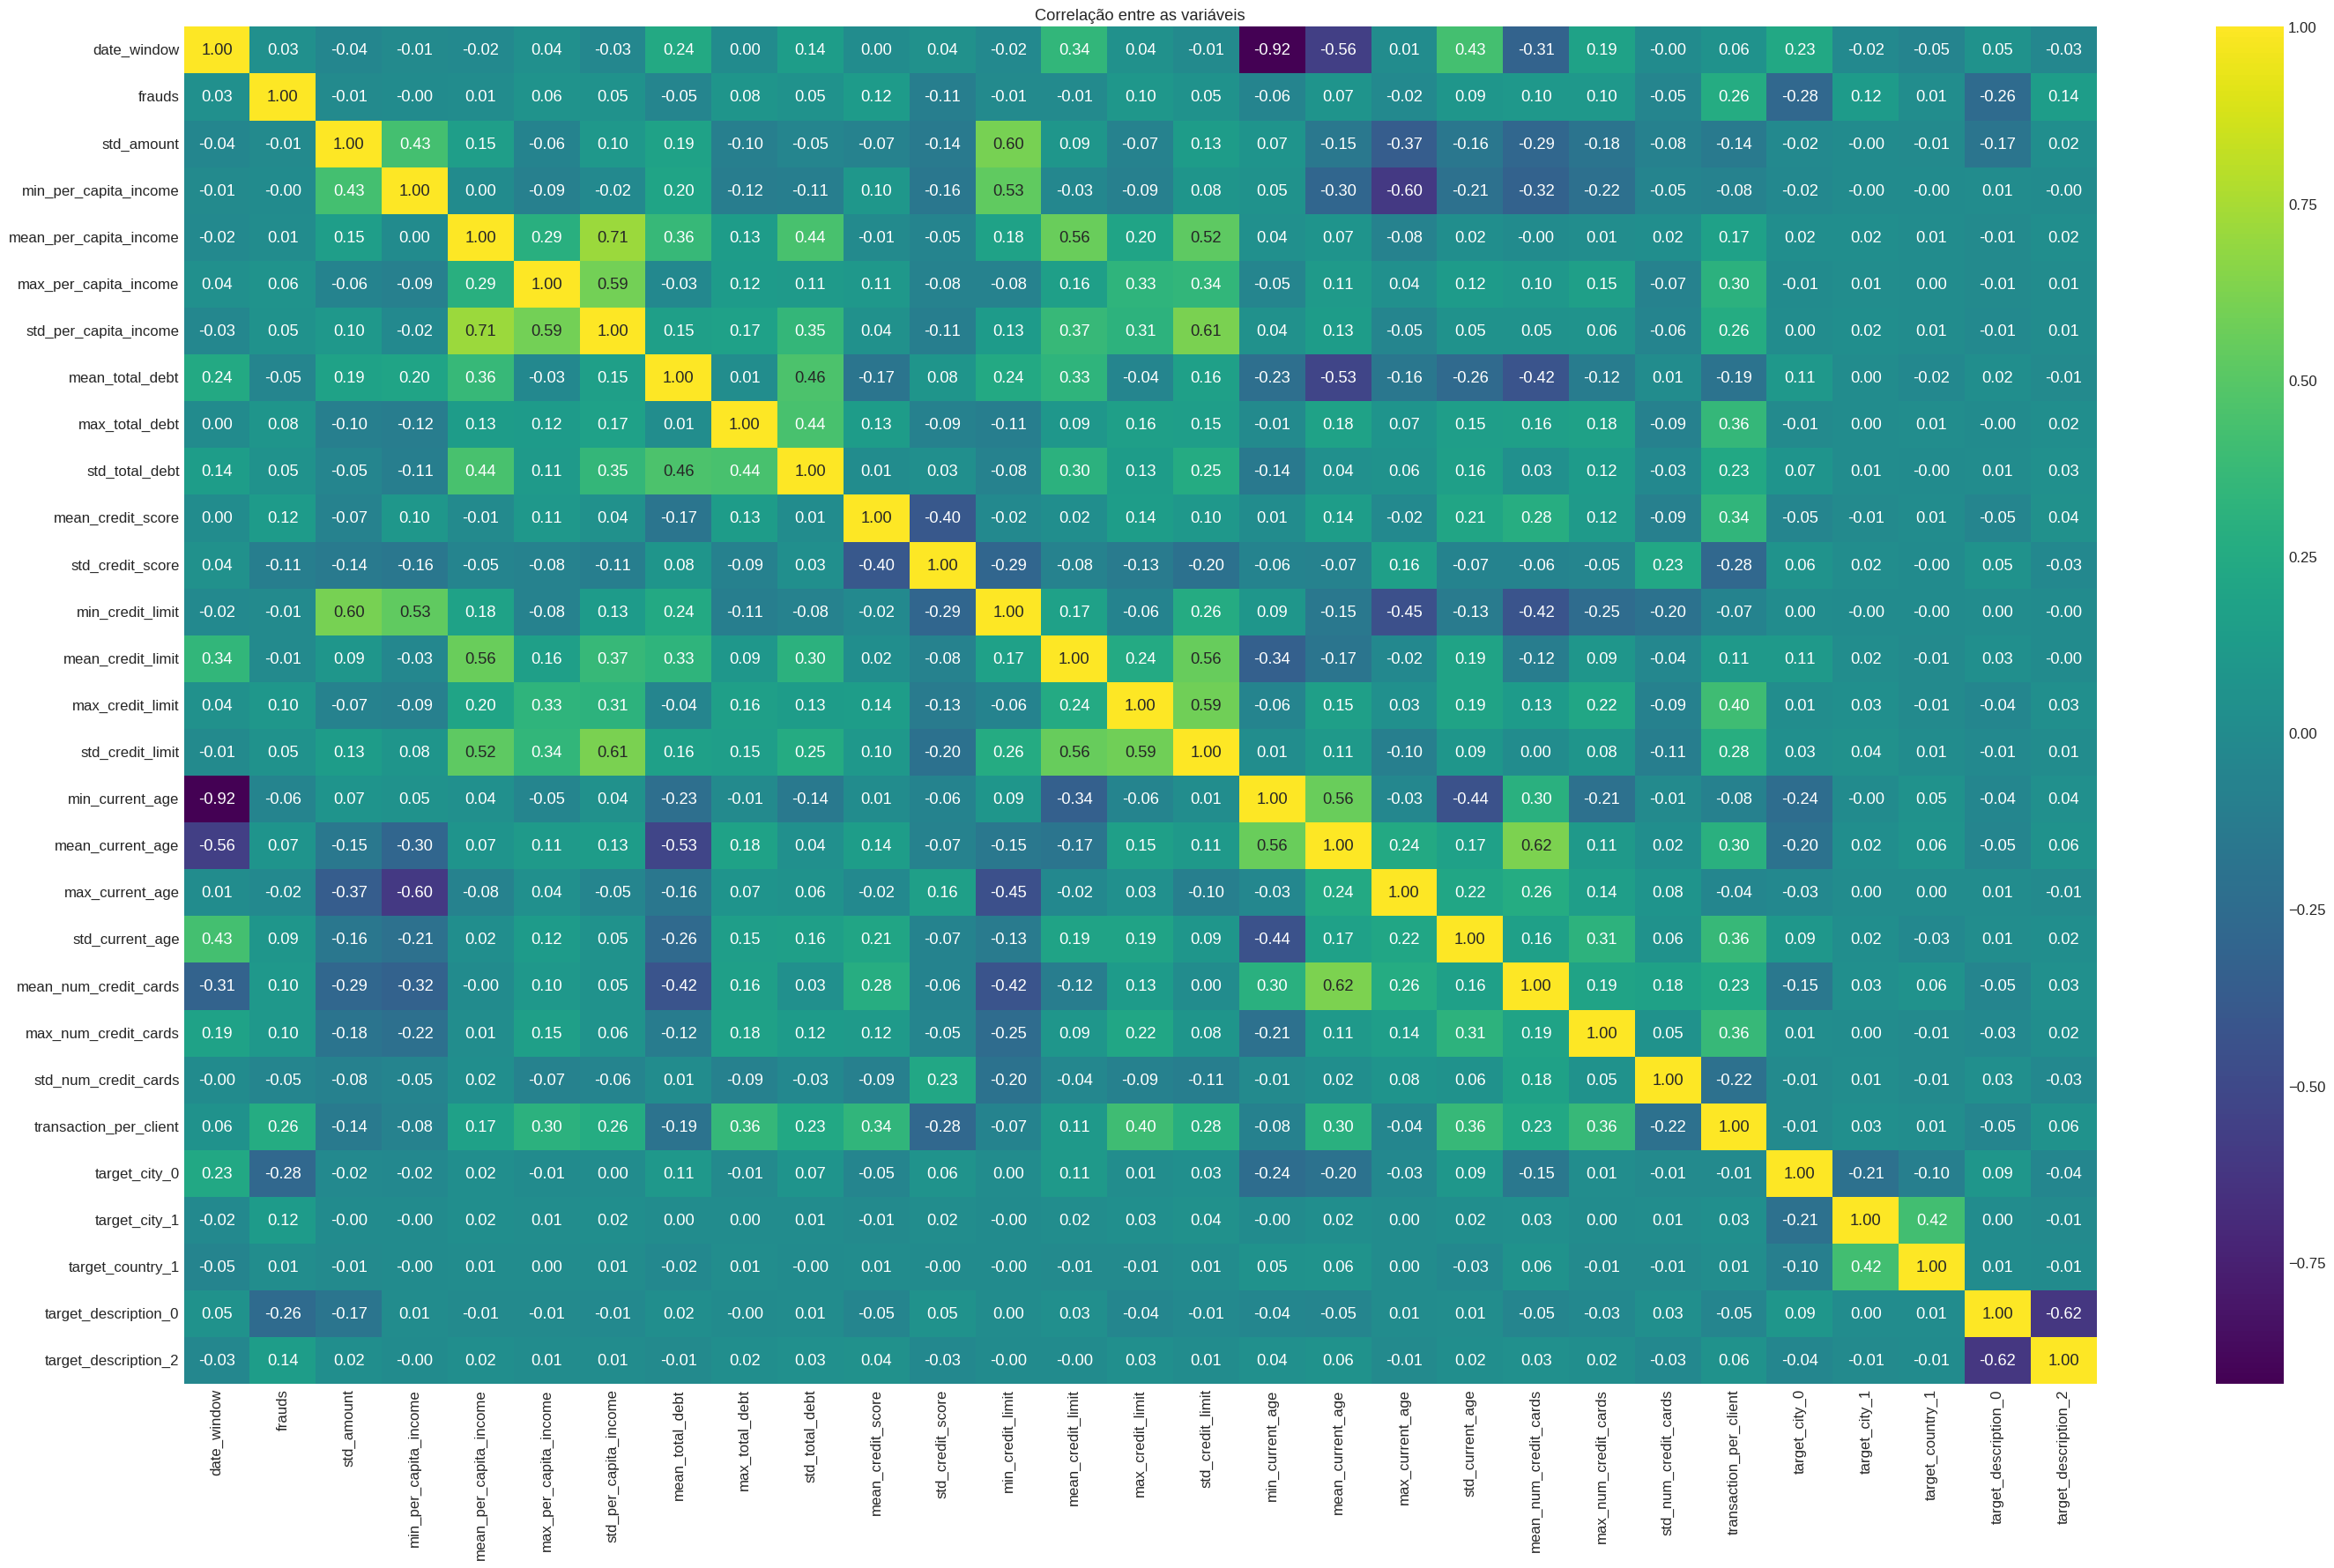

In [26]:
corr = selected_builder.df.corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

In [102]:
X = selected_builder.df.drop(columns=['date_window']).copy()
y = X['frauds']

In [103]:
X.describe().T

count          mean        std        min  \
frauds                  5387.0  2.383887e+00   4.496938   0.000000   
std_amount              5387.0  7.340305e-02   0.014509   0.047448   
min_per_capita_income   5387.0  6.532578e-03   0.289701   0.000000   
mean_per_capita_income  5387.0  2.394482e+01   0.303430  21.167000   
max_per_capita_income   5387.0  1.494995e+02  20.890112  30.747000   
std_per_capita_income   5387.0  1.179839e+01   0.825447   5.599217   
mean_total_debt         5387.0  5.785738e+00   0.142536   5.276819   
max_total_debt          5387.0  4.469829e+01   4.536686  12.477100   
std_total_debt          5387.0  5.181740e+00   0.192354   3.678802   
mean_credit_score       5387.0  7.139771e+00   0.018170   7.071042   
std_credit_score        5387.0  6.580092e-01   0.015066   0.334215   
min_credit_limit        5387.0  2.532022e-05   0.001337   0.000000   
mean_credit_limit       5387.0  1.551976e+00   0.034343   1.179860   
max_credit_limit        5387.0  1.280519e+01   1.896859   2.519700   
std_credit_limit        5387.0  1.212376e+00   0.067416   0.963675   
min_current_age         5387.0  2.502766e+01   1.828259  23.000000   
mean_current_age        5387.0  5.404227e+01   0.652833  39.600000   
max_current_age         5387.0  1.004099e+02   1.290299  51.000000   
std_current_age         5387.0  1.570888e+01   0.321633  11.148991   
mean_num_credit_cards   5387.0  3.846110e+00   0.050433   2.333333   
max_num_credit_cards    5387.0  8.881195e+00   0.333757   3.000000   
std_num_credit_cards    5387.0  1.571884e+00   0.028041   1.154701   
transaction_per_client  5387.0  1.926992e+00   0.221851   1.000000   
target_city_0           5387.0  9.999643e-01   0.000212   0.995633   
target_city_1           5387.0  3.073342e-06   0.000046   0.000000   
target_country_1        5387.0  5.816572e-07   0.000019   0.000000   
target_description_0    5387.0  9.999452e-01   0.000197   0.997971   
target_description_2    5387.0  2.266548e-05   0.000121   0.000000   

                               25%         50%         75%         max  
frauds                    0.000000    0.000000    3.000000   39.000000  
std_amount                0.065532    0.071971    0.079105    0.699717  
min_per_capita_income     0.000000    0.000000    0.000000   16.823000  
mean_per_capita_income   23.748599   23.942059   24.146754   28.301333  
max_per_capita_income   137.428000  163.145000  163.145000  163.145000  
std_per_capita_income    11.236988   11.782586   12.345386   20.099684  
mean_total_debt           5.691565    5.783895    5.875766    8.172533  
max_total_debt           46.185400   46.185400   46.185400   46.185400  
std_total_debt            5.057725    5.179750    5.308763    5.948495  
mean_credit_score         7.128469    7.140379    7.152305    7.314000  
std_credit_score          0.648508    0.657727    0.667115    0.721367  
min_credit_limit          0.000000    0.000000    0.000000    0.097400  
mean_credit_limit         1.529674    1.552228    1.574568    2.027600  
max_credit_limit         12.572300   13.766900   14.139100   14.139100  
std_credit_limit          1.169247    1.211835    1.254146    2.517700  
min_current_age          23.000000   25.000000   27.000000   36.000000  
mean_current_age         53.633114   54.028046   54.456845   56.378527  
max_current_age          99.000000  101.000000  101.000000  101.000000  
std_current_age          15.513822   15.731970   15.931134   16.613716  
mean_num_credit_cards     3.817592    3.846800    3.875979    4.013323  
max_num_credit_cards      9.000000    9.000000    9.000000    9.000000  
std_num_credit_cards      1.553549    1.571099    1.589609    1.691072  
transaction_per_client    1.670088    2.020089    2.110461    2.348214  
target_city_0             1.000000    1.000000    1.000000    1.000000  
target_city_1             0.000000    0.000000    0.000000    0.001091  
target_country_1          0.000000    0.000000    0.000000    0.000660  
target_description_0   

In [104]:
y.value_counts()

frauds
0     3283
1      374
2      263
3      242
4      185
5      172
6      127
7      111
8      105
10      75
9       72
11      71
12      58
13      49
15      30
14      29
17      27
16      22
21      14
20      13
18      12
19      10
25       9
22       8
23       6
24       5
28       4
26       4
27       2
29       1
32       1
39       1
38       1
31       1
Name: count, dtype: int64

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [105]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [106]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds']).columns)
formula

'frauds ~ std_amount + min_per_capita_income + mean_per_capita_income + max_per_capita_income + std_per_capita_income + mean_total_debt + max_total_debt + std_total_debt + mean_credit_score + std_credit_score + min_credit_limit + mean_credit_limit + max_credit_limit + std_credit_limit + min_current_age + mean_current_age + max_current_age + std_current_age + mean_num_credit_cards + max_num_credit_cards + std_num_credit_cards + transaction_per_client + target_city_0 + target_city_1 + target_country_1 + target_description_0 + target_description_2'

In [107]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()

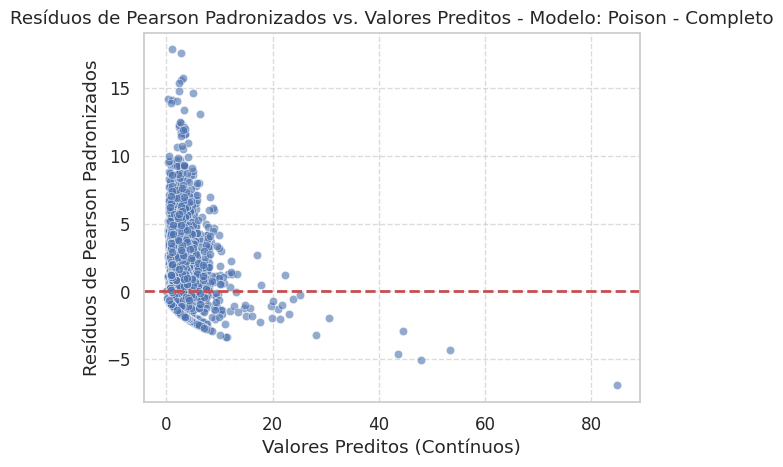

In [108]:
overdisp_plot(modelo_poisson, 'Poison - Completo')

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [109]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.066     
Dependent Variable:     ystar            AIC:                         44912.9601
Date:                   2025-08-17 14:18 BIC:                         44919.5519
No. Observations:       5387             Log-Likelihood:              -22455.   
Df Model:               1                F-statistic:                 380.7     
Df Residuals:           5386             Prob (F-statistic):          5.69e-82  
R-squared (uncentered): 0.066            Scale:                       244.50    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1839         0.0607       19.5107       0.0000       1.0650       1.3029
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [110]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('std_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('std_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('min_credit_limit') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('std_credit_limit') + Q('min_current_age') + Q('mean_current_age') + Q('max_current_age') + Q('std_current_age') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('std_num_credit_cards') + Q('transaction_per_client') + Q('target_city_0') + Q('target_city_1') + Q('target_country_1') + Q('target_description_0') + Q('target_description_2')

 Family type...: 
 Poisson

 Discarding atribute "Q('std_num_credit_cards')" with p-value equal to 0.6942448258497358 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('std_per

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5372
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16119.
Date:                Sun, 17 Aug 2025   Deviance:                       25253.
Time:                        14:18:16   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7554
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2235.1813     39.775     56.196      0.000    2157.224    2313.139
Q('std_amount')                -5.0550      0.820     -6.164      0.000      -6.662      -3.448
Q('min_per_capita_income')      0.1491      0.039      3.778      0.000       0.072       0.226
Q('mean_credit_score')          1.9527      0.571      3.421      0.001       0.834       3.072
Q('mean_credit_limit')         -3.7282      0.370    -10.069      0.000      -4.454      -3.002
Q('std_credit_limit')           0.3835      0.184      2.085      0.037       0.023       0.744
Q('min_current_age')           -0.1717      0.007    -23.959      0.000      -0.186      -0.158
Q('std_current_age')           -0.1972      0.038     -5.206      0.000      -0.271      -0.123
Q('mean_num_credit_cards')      2.7345      0.254     10.759      0.000       2.236       3.233
Q('transaction_per_client')     2.4565      0.054     45.392      0.000       2.350       2.563
Q('target_city_0')           -895.6983     19.297    -46.417      0.000    -933.519    -857.878
Q('target_city_1')           1066.3911     91.511     11.653      0.000     887.033    1245.749
Q('target_country_1')       -1086.0387    387.488     -2.803      0.005   -1845.501    -326.577
Q('target_description_0')   -1355.0969     35.558    -38.109      0.000   -1424.790   -1285.404
Q('target_description_2')    -188.1843     61.196     -3.075      0.002    -308.125     -68.243
===============================================================================================
"""

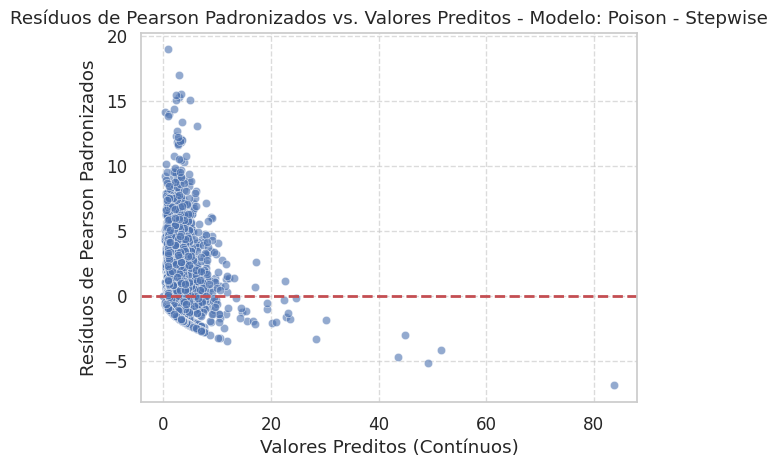

In [111]:
overdisp_plot(modelo_poisson_stepwise, 'Poison - Stepwise')

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [112]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.065     
Dependent Variable:     ystar            AIC:                         45005.9395
Date:                   2025-08-17 14:18 BIC:                         45012.5312
No. Observations:       5387             Log-Likelihood:              -22502.   
Df Model:               1                F-statistic:                 374.7     
Df Residuals:           5386             Prob (F-statistic):          9.40e-81  
R-squared (uncentered): 0.065            Scale:                       248.76    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1866         0.0613       19.3566       0.0000       1.0664       1.3068
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [113]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

#### Implementação dos modelos

##### Completo

In [114]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5359
Model Family:        NegativeBinomial   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9984.8
Date:                Sun, 17 Aug 2025   Deviance:                       9133.9
Time:                        14:18:26   Pearson chi2:                 1.04e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3305
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3132.7450    122.854     25.500      0.000    2891.956    3373.534
std_amount                -4.5899      1.622     -2.830      0.005      -7.769      -1.411
min_per_capita_income      0.0943      0.101      0.933      0.351      -0.104       0.292
mean_per_capita_income    -0.0616      0.107     -0.575      0.565      -0.272       0.148
max_per_capita_income     -0.0020      0.001     -1.744      0.081      -0.004       0.000
std_per_capita_income      0.0365      0.041      0.882      0.378      -0.045       0.118
mean_total_debt            0.2301      0.213      1.081      0.280      -0.187       0.647
max_total_debt            -0.0042      0.005     -0.838      0.402      -0.014       0.006
std_total_debt             0.1625      0.139      1.172      0.241      -0.109       0.434
mean_credit_score          2.6621      1.169      2.277      0.023       0.371       4.954
std_credit_score           0.2997      1.420      0.211      0.833      -2.484       3.084
min_credit_limit         -68.9092    175.639     -0.392      0.695    -413.155     275.337
mean_credit_limit         -3.3892      0.809     -4.191      0.000      -4.974      -1.804
max_credit_limit          -0.0077      0.013     -0.591      0.555      -0.033       0.018
std_credit_limit           0.3462      0.466      0.743      0.458      -0.567       1.260
min_current_age           -0.1682      0.017     -9.791      0.000      -0.202      -0.135
mean_current_age          -0.0652      0.053     -1.234      0.217      -0.169       0.038
max_current_age           -0.0032      0.018     -0.179      0.858      -0.038       0.032
std_current_age           -0.1740      0.081     -2.154      0.031      -0.332      -0.016
mean_num_credit_cards      2.8546      0.530      5.385      0.000       1.816       3.894
max_num_credit_cards       0.1105      0.067      1.642      0.101      -0.021       0.242
std_num_credit_cards       0.0053      0.702      0.008      0.994      -1.371       1.382
transaction_per_client     2.3097      0.114     20.204      0.000       2.086       2.534
target_city_0          -1588.4539     73.870    -21.503      0.000   -1733.236   -1443.672
target_city_1            911.2838    351.212      2.595      0.009     222.922    1599.646
target_country_1       -1447.5924    892.587     -1.622      0.105   -3197.031     301.846
target_description_0   -1564.0628    101.650    -15.387      0.000   -1763.293   -1364.832
target_description_2    -296.9480    161.789     -1.835      0.066    -614.048      20.152
==========================================================================================
"""

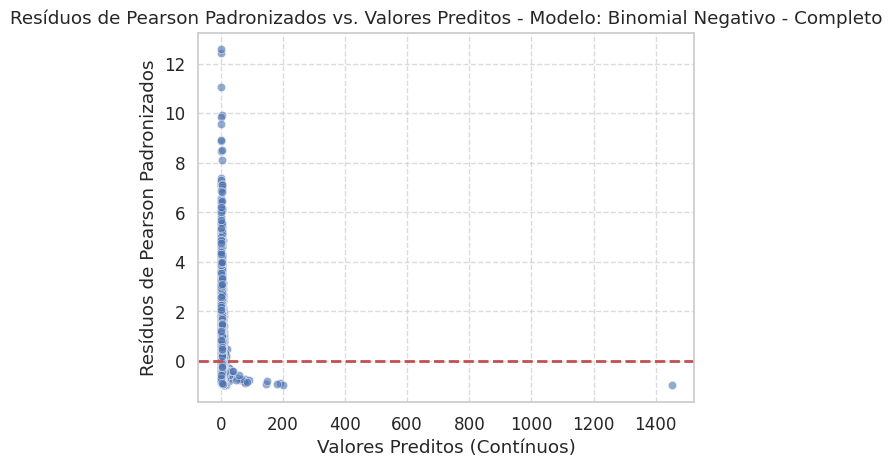

In [115]:
overdisp_plot(modelo_binomial, 'Binomial Negativo - Completo')

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

##### Stepwise

In [116]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('std_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('std_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('min_credit_limit') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('std_credit_limit') + Q('min_current_age') + Q('mean_current_age') + Q('max_current_age') + Q('std_current_age') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('std_num_credit_cards') + Q('transaction_per_client') + Q('target_city_0') + Q('target_city_1') + Q('target_country_1') + Q('target_description_0') + Q('target_description_2')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('std_num_credit_cards')" with p-value equal to 0.9939627613191802 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5375
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9993.3
Date:                Sun, 17 Aug 2025   Deviance:                       9150.9
Time:                        14:18:29   Pearson chi2:                 1.05e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3283
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2989.5924    105.398     28.365      0.000    2783.016    3196.168
Q('std_amount')                -3.6250      1.572     -2.306      0.021      -6.706      -0.544
Q('mean_total_debt')            0.4176      0.156      2.683      0.007       0.113       0.723
Q('mean_credit_score')          2.7565      1.086      2.539      0.011       0.629       4.884
Q('mean_credit_limit')         -3.3258      0.603     -5.519      0.000      -4.507      -2.145
Q('min_current_age')           -0.1828      0.013    -13.633      0.000      -0.209      -0.157
Q('std_current_age')           -0.1790      0.074     -2.435      0.015      -0.323      -0.035
Q('mean_num_credit_cards')      2.6698      0.477      5.600      0.000       1.735       3.604
Q('transaction_per_client')     2.2948      0.092     25.026      0.000       2.115       2.475
Q('target_city_0')          -1583.0413     73.205    -21.625      0.000   -1726.520   -1439.563
Q('target_city_1')            708.1579    322.259      2.197      0.028      76.541    1339.775
Q('target_description_0')   -1430.0875     79.725    -17.938      0.000   -1586.345   -1273.830
===============================================================================================
"""

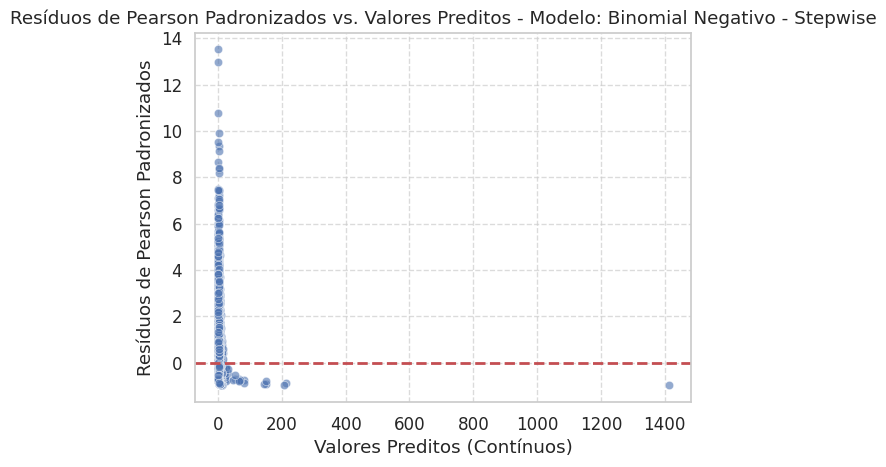

In [117]:
overdisp_plot(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

O modelo stepwise apresenta o mesmo comportamento em relação ao modelo completo.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

In [118]:
X1 = X.drop(columns=['frauds']).copy()
X1 = sm.add_constant(X1)

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [119]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [120]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1', maxiter=50)
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 5387
Model:             ZeroInflatedPoisson   Df Residuals:                     5359
Method:                            MLE   Df Model:                           27
Date:                 Sun, 17 Aug 2025   Pseudo R-squ.:                 -0.5638
Time:                         14:18:42   Log-Likelihood:                -17887.
converged:                       False   LL-Null:                       -11438.
Covariance Type:                   HC1   LLR p-value:                     1.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                      0.0954    687.549      0.000      1.000   -1347.477    1347.667
inflate_std_amount                 0.0985      6.748      0.015      0.988     -13.127      13.324
inflate_min_per_capita_income      0.0822      0.357      0.230      0.818      -0.617       0.781
inflate_mean_per_capita_income    -0.0181      0.296     -0.061      0.951      -0.599       0.562
inflate_max_per_capita_income     -0.4051      0.003   -127.985      0.000      -0.411      -0.399
inflate_std_per_capita_income      0.0305      0.107      0.285      0.775      -0.179       0.240
inflate_mean_total_debt            0.0690      0.549      0.126      0.900      -1.006       1.144
inflate_max_total_debt            -0.0471      0.018     -2.684      0.007      -0.081      -0.013
inflate_std_total_debt             0.0779      0.355      0.220      0.826      -0.617       0.773
inflate_mean_credit_score          0.0672      3.530      0.019      0.985      -6.851       6.986
inflate_std_credit_score           0.0976      4.177      0.023      0.981      -8.089       8.284
inflate_min_credit_limit           0.0998    445.847      0.000      1.000    -873.744     873.943
inflate_mean_credit_limit          0.0920      2.243      0.041      0.967      -4.305       4.489
inflate_max_credit_limit           0.0555      0.036      1.556      0.120      -0.014       0.125
inflate_std_credit_limit           0.0920      1.219      0.075      0.940      -2.298       2.482
inflate_min_current_age           -0.0352      0.048     -0.729      0.466      -0.130       0.059
inflate_mean_current_age          -0.1377      0.153     -0.899      0.369      -0.438       0.163
inflate_max_current_age           -0.2916      0.054     -5.402      0.000      -0.397      -0.186
inflate_std_current_age            0.0325      0.271      0.120      0.905      -0.499       0.564
inflate_mean_num_credit_cards      0.0851      1.787      0.048      0.962      -3.417       3.588
inflate_max_num_credit_cards       0.0699      0.152      0.461      0.645      -0.227       0.367
inflate_std_num_credit_cards       0.0935      2.038      0.046      0.963      -3.900       4.087
inflate_transaction_per_client     0.0928      0.381      0.243      0.808      -0.655       0.840
inflate_target_city_0              0.0954    201.403      0.000      1.000    -394.647     394.837
inflate_target_city_1              0.1000    398.068      0.000      1.000    -780.099     780.299
inflate_target_country_1           0.1000    830.916      0.000      1.000   -1628.466    1628.666
inflate_target_description_0       0.0954    735.903      0.000      1.000   -1442.247    1442.438
inflate_target_description_2       0.1000    827.068      0.000      1.000   -1620.923    1621.123
const                              0.3236    410.101      0.001      0.999    -803.460     804.107
std_amount                         0.8416      2.443      0.344 

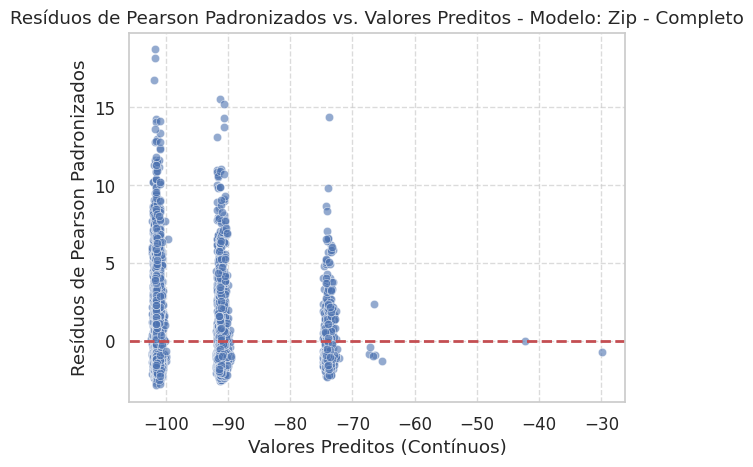

In [121]:
overdisp_plot(modelo_zip, 'Zip - Completo')

Igual ao modelo Poisson, o modelo ZIP apresenta problemas de sobredispersão, quando a média é menor que a variância. O modelo tem diculdades para modelar os componentes de contagem e zeros estruturais uma vez que o presuposto do modelo Poisson não foi atendido e todos as features foram incluídas em ambos componentes.

In [122]:
vuong_test(modelo_poisson, modelo_zip)

Optimization terminated successfully.
         Current function value: 2.990486
         Iterations 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: 13.008
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [123]:
X1 = X.drop(columns=['frauds']).copy()

In [49]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
    convergence_strictness='low'
  )
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X1, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(convergence_strictness='low',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=42,
                      scoring_fn=<function <lambda> at 0x7cc63819e480>)

In [125]:
modelo_zip_stepwise = random_selector.best_estimator_.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5387
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     5385
Method:                                      MLE   Df Model:                            1
Date:                           Sun, 17 Aug 2025   Pseudo R-squ.:                 0.03259
Time:                                   14:19:07   Log-Likelihood:                -9027.1
converged:                                  True   LL-Null:                       -9331.2
Covariance Type:                       nonrobust   LLR p-value:                2.744e-134
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
inflate_const                49.5773     12.431      3.988      0.000      25.214      73.941
inflate_mean_credit_score    -7.1219      1.747     -4.077      0.000     -10.546      -3.698
inflate_std_credit_limit      1.2304      0.483      2.548      0.011       0.284       2.177
const                        -3.2088      0.190    -16.861      0.000      -3.582      -2.836
transaction_per_client        2.4594      0.095     25.918      0.000       2.273       2.645
alpha                         0.5777      0.035     16.644      0.000       0.510       0.646
=============================================================================================
"""

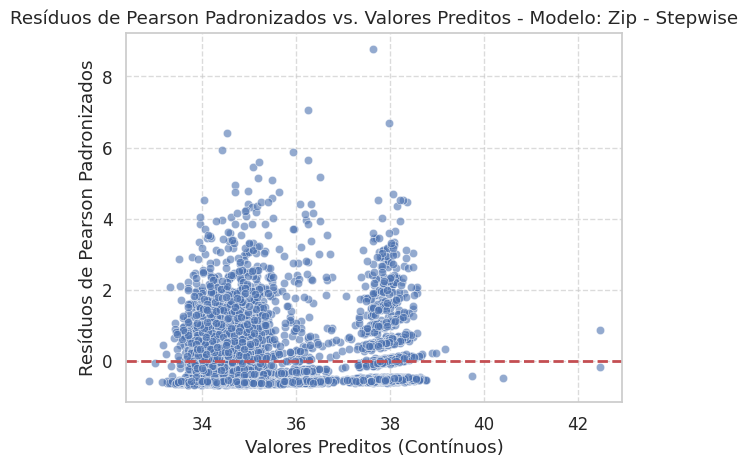

In [126]:
overdisp_plot(modelo_zip_stepwise, 'Zip - Stepwise')

O modelo apresentou uma melhora significativa em relação ao modelo zip completo uma vez que agora os residuos estão bem mais espelhados em torno da linha vermelha (y=0). No entanto ainda é perceptivo uma dispersão maior ao longo que os valores preditos aumentam, indicando ainda sobredispersão.

In [127]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

Optimization terminated successfully.
         Current function value: 2.992287
         Iterations 16
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -32.083
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [128]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

##### Completo

In [129]:
X1 = X.drop(columns=['frauds']).copy(deep=True)
X1 = sm.add_constant(X1)

In [130]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 5387
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     5359
Method:                                      MLE   Df Model:                           27
Date:                           Sun, 17 Aug 2025   Pseudo R-squ.:                 0.04578
Time:                                   14:19:49   Log-Likelihood:                -8904.0
converged:                                 False   LL-Null:                       -9331.2
Covariance Type:                             HC1   LLR p-value:                1.394e-162
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                     -0.0077     41.233     -0.000      1.000     -80.824      80.808
inflate_std_amount                -0.0097      3.179     -0.003      0.998      -6.240       6.221
inflate_min_per_capita_income     -0.3183      0.101     -3.162      0.002      -0.516      -0.121
inflate_mean_per_capita_income     0.3191      0.204      1.565      0.118      -0.081       0.719
inflate_max_per_capita_income      0.0046      0.002      2.125      0.034       0.000       0.009
inflate_std_per_capita_income     -0.1276      0.079     -1.614      0.107      -0.283       0.027
inflate_mean_total_debt            0.0172      0.421      0.041      0.967      -0.809       0.843
inflate_max_total_debt             0.0028      0.010      0.284      0.776      -0.016       0.022
inflate_std_total_debt             0.1659      0.268      0.620      0.535      -0.359       0.691
inflate_mean_credit_score         -0.1361      5.889     -0.023      0.982     -11.679      11.407
inflate_std_credit_score           0.0331      4.776      0.007      0.994      -9.329       9.395
inflate_min_credit_limit       -2.495e-05     85.261  -2.93e-07      1.000    -167.108     167.108
inflate_mean_credit_limit          0.1313      1.825      0.072      0.943      -3.446       3.709
inflate_max_credit_limit           0.0038      0.025      0.149      0.882      -0.046       0.054
inflate_std_credit_limit           0.1228      0.912      0.135      0.893      -1.665       1.910
inflate_min_current_age            0.0613      0.032      1.889      0.059      -0.002       0.125
inflate_mean_current_age          -0.2208      0.109     -2.019      0.044      -0.435      -0.006
inflate_max_current_age           -0.0169      0.035     -0.480      0.631      -0.086       0.052
inflate_std_current_age            0.4245      0.153      2.774      0.006       0.125       0.724
inflate_mean_num_credit_cards     -0.2761      1.021     -0.271      0.787      -2.276       1.724
inflate_max_num_credit_cards      -0.0594      0.138     -0.429      0.668      -0.330       0.211
inflate_std_num_credit_cards       0.0150      1.373      0.011      0.991      -2.675       2.705
inflate_transaction_per_client    -0.1165      0.220     -0.529      0.597      -0.548       0.315
inflate_target_city_0             -0.0029     54.499  -5.39e-05      1.000    -106.820     106.814
inflate_target_city_1             -0.0005    114.076  -4.02e-06      1.000    -223.586     223.585
inflate_target_country_1        -8.08e-05     89.265  -9.05e-07      1.000    -174.957     174.957
inflate_target_description_0      -0.0040     62.132  -6.45e-05      1.000    -121.781     121.773
inflate_target_description_2      -0.0011      9.097     -0.000      1.000     -17.831      17.829
const                           2229.1978     18.420    121.020      0.00

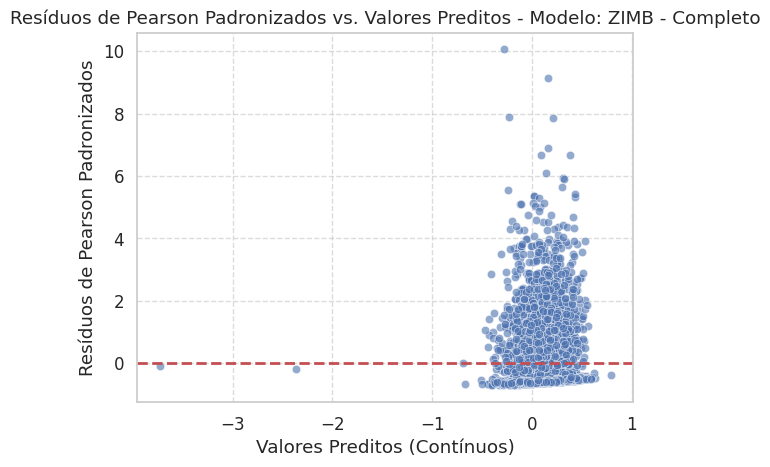

In [131]:
overdisp_plot(modelo_zinb, 'ZIMB - Completo')

O gráfico mostra que o modelo prevê quase sempre valores próximos de zero, mas quando ocorrem contagens positivas ele não consegue explicar bem, gerando erros muito grandes.
Isso significa que o modelo está superestimando zeros e subestimando casos com eventos reais.
Os resíduos deveriam se espalhar de forma equilibrada em torno de zero, mas aqui aparecem concentrados e com cauda longa para cima, sinal claro de mau ajuste.

In [132]:
vuong_test(modelo_binomial, modelo_zinb)

         Current function value: 1.696989
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -11.899
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


##### Stepwise

In [133]:
X1 = X.drop(columns=['frauds']).copy()

In [59]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
    convergence_strictness='low'
  )
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X1, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(convergence_strictness='low',
                                                           model_type='ZINB',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=42,
                      scoring_fn=<function <lambda> at 0x7cc91c14c7c0>)

In [134]:
modelo_zinb_stepwise = random_selector.best_estimator_.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5387
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     5385
Method:                                      MLE   Df Model:                            1
Date:                           Sun, 17 Aug 2025   Pseudo R-squ.:                 0.03259
Time:                                   14:20:09   Log-Likelihood:                -9027.1
converged:                                  True   LL-Null:                       -9331.2
Covariance Type:                       nonrobust   LLR p-value:                2.744e-134
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
inflate_const                49.5773     12.431      3.988      0.000      25.214      73.941
inflate_mean_credit_score    -7.1219      1.747     -4.077      0.000     -10.546      -3.698
inflate_std_credit_limit      1.2304      0.483      2.548      0.011       0.284       2.177
const                        -3.2088      0.190    -16.861      0.000      -3.582      -2.836
transaction_per_client        2.4594      0.095     25.918      0.000       2.273       2.645
alpha                         0.5777      0.035     16.644      0.000       0.510       0.646
=============================================================================================
"""

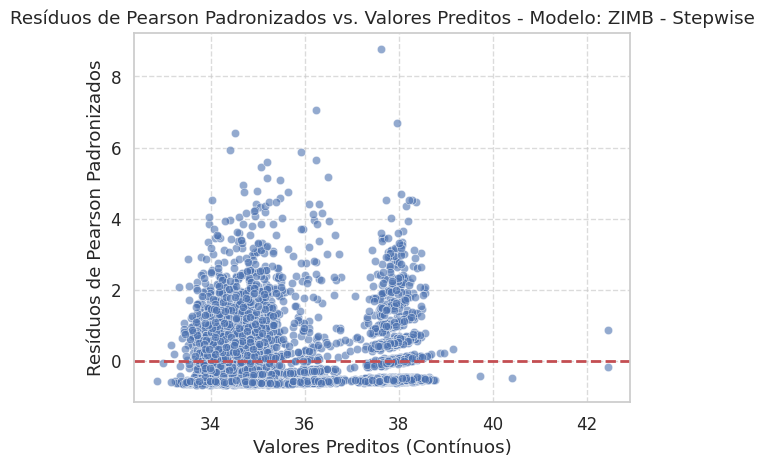

In [135]:
overdisp_plot(modelo_zinb_stepwise, 'ZIMB - Stepwise')

O modelo stepwise apresenta previsões mais altas e consistentes, evitando o excesso de zeros visto no modelo anterior.
Os resíduos estão mais próximos de zero e com menor amplitude, sinal de um ajuste mais estável.
Ainda assim, surgem faixas verticais de pontos, indicando previsões pouco flexíveis e repetitivas.
Existem alguns resíduos acima de 5, mostrando que erros relevantes ainda ocorrem.

In [136]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

         Current function value: 1.697472
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -4.608
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


### Treinamento Manual

In [137]:
X.columns.to_list()

['frauds',
 'std_amount',
 'min_per_capita_income',
 'mean_per_capita_income',
 'max_per_capita_income',
 'std_per_capita_income',
 'mean_total_debt',
 'max_total_debt',
 'std_total_debt',
 'mean_credit_score',
 'std_credit_score',
 'min_credit_limit',
 'mean_credit_limit',
 'max_credit_limit',
 'std_credit_limit',
 'min_current_age',
 'mean_current_age',
 'max_current_age',
 'std_current_age',
 'mean_num_credit_cards',
 'max_num_credit_cards',
 'std_num_credit_cards',
 'transaction_per_client',
 'target_city_0',
 'target_city_1',
 'target_country_1',
 'target_description_0',
 'target_description_2']

In [146]:
X1 = X[['std_amount']]
X1 = sm.add_constant(X1)

X2 = X[['std_amount']]
X2 = sm.add_constant(X2)

In [147]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2).fit(disp=False, cov_type='HC1')
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 5387
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     5385
Method:                                      MLE   Df Model:                            1
Date:                           Sun, 17 Aug 2025   Pseudo R-squ.:               1.933e-05
Time:                                   14:22:01   Log-Likelihood:                -9331.0
converged:                                 False   LL-Null:                       -9331.2
Covariance Type:                             HC1   LLR p-value:                    0.5481
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const          0.0920      0.191      0.482      0.630      -0.283       0.467
inflate_std_amount     0.4183      2.563      0.163      0.870      -4.605       5.442
const                  1.6908      0.172      9.825      0.000       1.354       2.028
std_amount            -0.8343      2.348     -0.355      0.722      -5.436       3.768
alpha                  1.0100      0.065     15.500      0.000       0.882       1.138
======================================================================================
"""

## Comparação dos modelos

### Comparação dos modelos com base em seu Log-Likelihood Function (LLF)

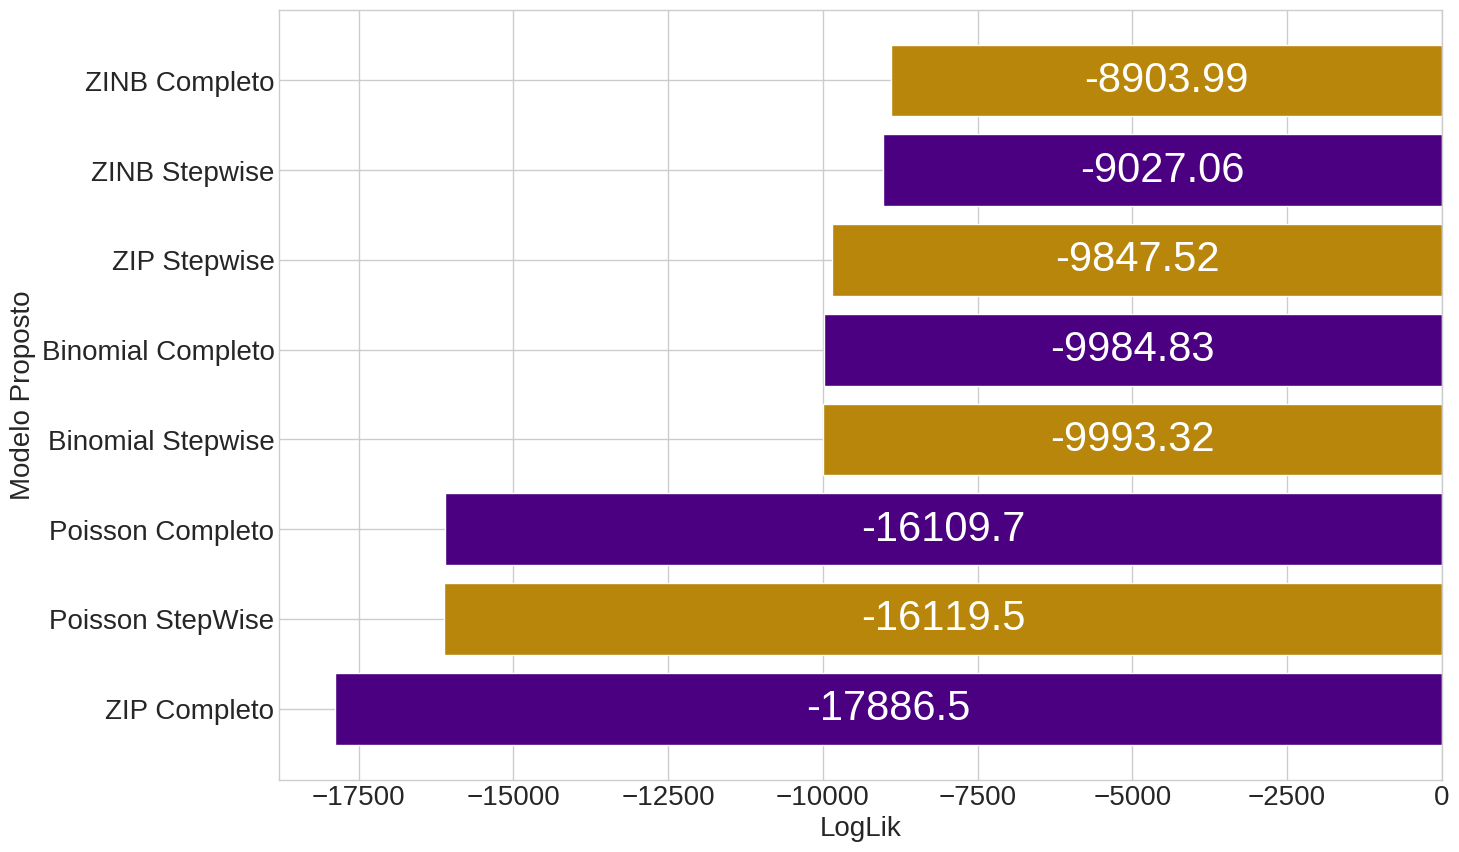

In [63]:
compare_models({
    'modelo':[
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poisson.llf,
        modelo_poisson_stepwise.llf,
        modelo_binomial.llf,
        modelo_binomial_stepwise.llf,
        modelo_zip.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb.llf,
        modelo_zinb_stepwise.llf
      ]
})

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

In [64]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

### Dispersão dos residuos

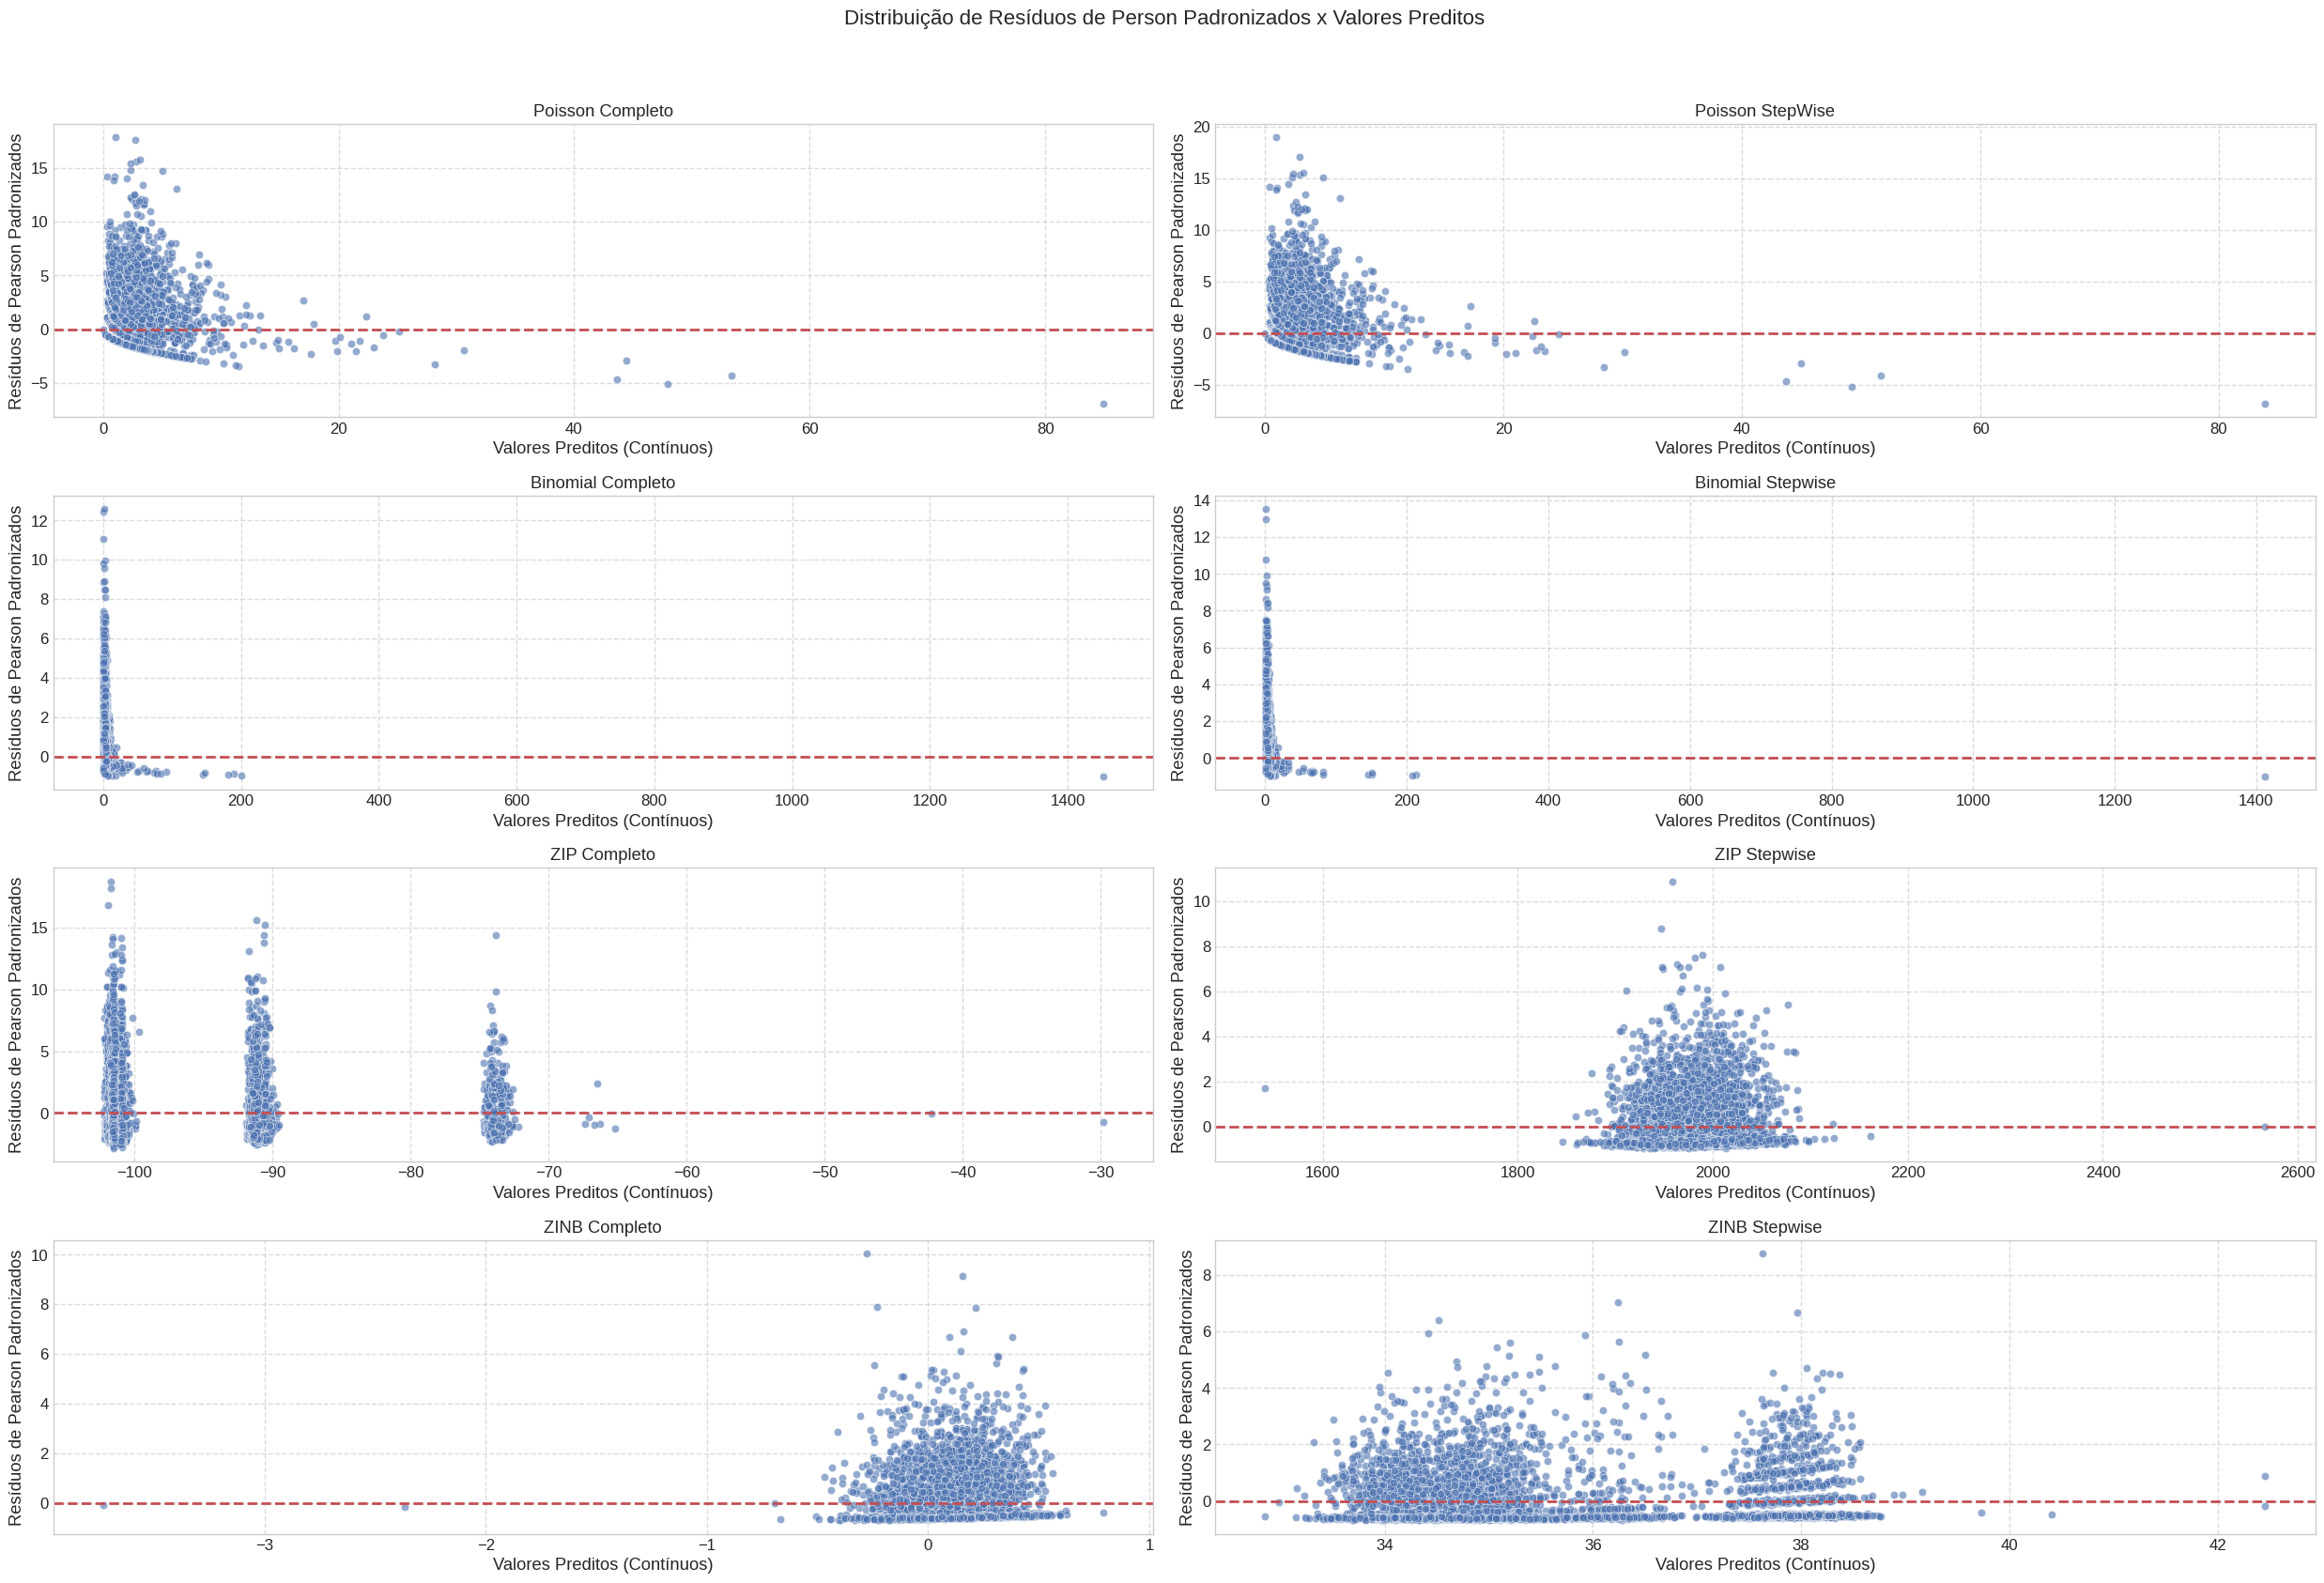

In [65]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

Com base nos residuos de cada modelos em relação ao valor predito, podemos observar que o modelo ZINB Stepwise apresenta uma melhor distribuição dos residuos não apresentando um padrão fixo nos dados, sua dispersão é a menor em relação aos outros modelos e com poucos pontos extremos.

### Análise das métricas dos modelos

In [66]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

  if np.isnan(model.llf):
    continue

  rmse_resid = np.sqrt(np.mean(model.resid_pearson**2))
  outliers = np.sum(np.abs(model.resid_pearson) > 2)

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()
  metric['RMSE_Pearson'] = rmse_resid
  metric['Outliers'] = outliers

  metrics.append(metric)

In [67]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

title           LLF           BIC           AIC  Converged  \
0      ZINB Completo  -8903.990472  18297.710348  17921.980944      False   
1      ZINB Stepwise  -9027.056918  18105.664300  18066.113836       True   
2       ZIP Stepwise  -9847.518903  19798.138732  19719.037805       True   
3  Binomial Completo  -9984.830575 -36909.220090  20025.661150       True   
4  Binomial Stepwise  -9993.320808 -37029.707527  20010.641616       True   
5   Poisson Completo -16109.748245 -20809.244797  32275.496490       True   
6   Poisson StepWise -16119.450433 -20901.533092  32268.900866       True   
7       ZIP Completo -17886.546832  36254.231323  35885.093664      False   

   PseudoR2  RMSE_Pearson  Outliers  
0  0.045779      1.028550       292  
1  0.032590      0.990669       301  
2  0.139057      1.190978       410  
3  0.330455      1.392263       486  
4  0.328341      1.392792       502  
5  0.756282      2.388539      1076  
6  0.755402      2.390838      1068  
7 -0.563774      2.575806      1213

In [68]:
df_metrics = df_metrics.query('Converged == True').sort_values(by=['LLF'], ascending=False).reset_index(drop=True)
df_metrics

title           LLF           BIC           AIC  Converged  \
0      ZINB Stepwise  -9027.056918  18105.664300  18066.113836       True   
1       ZIP Stepwise  -9847.518903  19798.138732  19719.037805       True   
2  Binomial Completo  -9984.830575 -36909.220090  20025.661150       True   
3  Binomial Stepwise  -9993.320808 -37029.707527  20010.641616       True   
4   Poisson Completo -16109.748245 -20809.244797  32275.496490       True   
5   Poisson StepWise -16119.450433 -20901.533092  32268.900866       True   

   PseudoR2  RMSE_Pearson  Outliers  
0  0.032590      0.990669       301  
1  0.139057      1.190978       410  
2  0.330455      1.392263       486  
3  0.328341      1.392792       502  
4  0.756282      2.388539      1076  
5  0.755402      2.390838      1068

Percebemos que o modelo com maior LLF não convergiu durante o treinamento, o que invalida sua escolha uma vez que os pesos obtidos não refletem a correta relação dos dados com o modelo escohido.

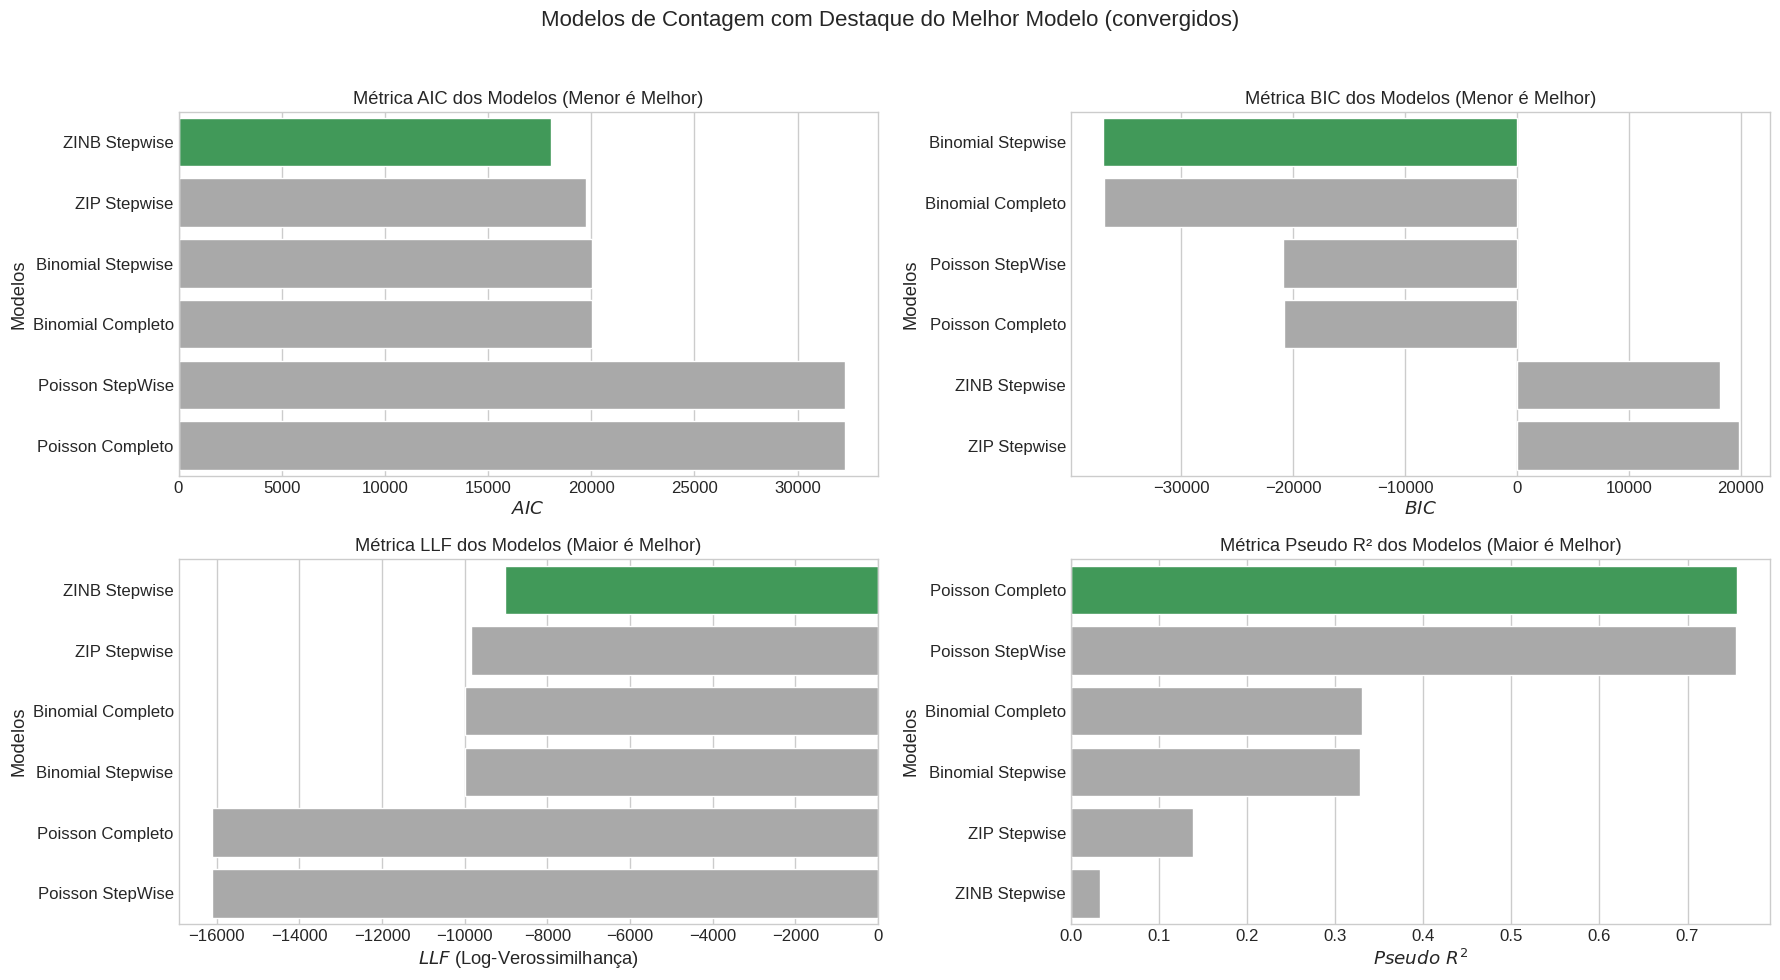

In [69]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

Podemos perceber que o modelo ZINB Stepwise se demonstra melhor em duas métricas, LLF e AIC, sendo assim a melhor escolha.

## Análise do melhor modelo

In [70]:
best_model = df_metrics.loc[0, 'title']
best_model

'ZINB Stepwise'

In [71]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5387
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     5385
Method:                                      MLE   Df Model:                            1
Date:                           Sun, 17 Aug 2025   Pseudo R-squ.:                 0.03259
Time:                                   13:34:12   Log-Likelihood:                -9027.1
converged:                                  True   LL-Null:                       -9331.2
Covariance Type:                       nonrobust   LLR p-value:                2.744e-134
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
inflate_const                49.5773     12.431      3.988      0.000      25.214      73.941
inflate_mean_credit_score    -7.1219      1.747     -4.077      0.000     -10.546      -3.698
inflate_std_credit_limit      1.2304      0.483      2.548      0.011       0.284       2.177
const                        -3.2088      0.190    -16.861      0.000      -3.582      -2.836
transaction_per_client        2.4594      0.095     25.918      0.000       2.273       2.645
alpha                         0.5777      0.035     16.644      0.000       0.510       0.646
=============================================================================================
"""

In [100]:
features_df = best_model.model.exog
feature_names = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_features = pd.DataFrame(features_df, columns=feature_names)
df_features['residuos'] = best_model.resid
df_features['fitted'] = best_model.fittedvalues
df_features['target'] = y
df_features

const  transaction_per_client  residuos     fitted  target
0       1.0                2.010724 -2.566821  34.984055       0
1       1.0                1.661765 -1.756026  36.484595       0
2       1.0                2.003846 -3.335635  34.570339       0
3       1.0                1.985602  3.905712  37.796704       5
4       1.0                1.607595 -1.235940  37.469982       0
...     ...                     ...       ...        ...     ...
5382    1.0                1.857995 -4.076636  34.196925       0
5383    1.0                1.614916  2.503542  34.494615       6
5384    1.0                2.110485 -0.992920  38.098387       0
5385    1.0                2.063404  2.901421  34.681565       6
5386    1.0                1.382609 -2.964121  34.916735       0

[5387 rows x 5 columns]

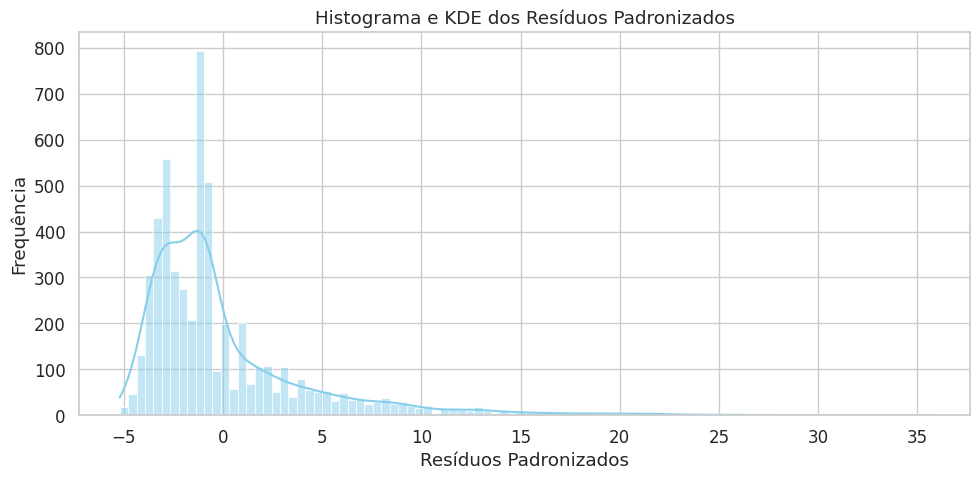

In [89]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

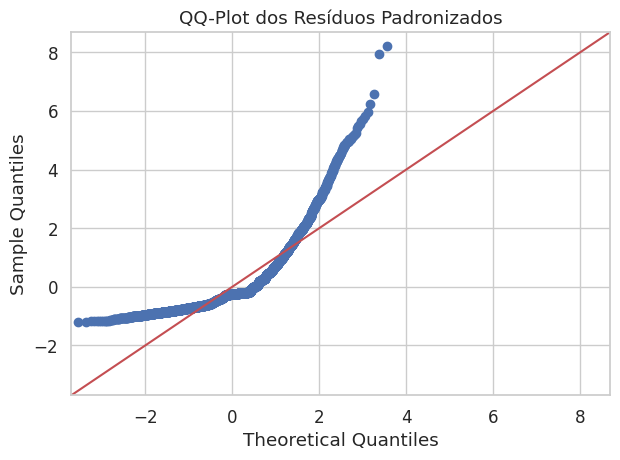

In [90]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

In [91]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[Shapiro-Wilk] Estatística: 0.7595 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


In [92]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

alpha = 0.05  # nível de significância
if dagostino_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[D’Agostino] Estatística: 2765.1954 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


In [93]:
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']

print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

# Define o nível de significância (alpha)
alpha = 0.05
p_valor_lm = bp_test[1] # p-valor da estatística LM é o mais comum

print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
print("H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).")
print("Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).")

if p_valor_lm < alpha:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MENOR que {alpha}.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.")
else:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MAIOR ou IGUAL a {alpha}.")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.")



[Breusch-Pagan]
LM Stat: 239.7043
LM p-val: 0.0000
F Stat: 250.7739
F p-val: 0.0000

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).
Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).

Resultado: O p-valor (0.0000) é MENOR que 0.05.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.


In [94]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])

print(f"\n--- Resultado do Teste de Durbin-Watson ---")
print(f"Estatística d: {dw_stat:.4f}")

# --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
print(f"\n--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---")
print("H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.")
print("Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.")

if dw_stat < 1.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MENOR que 1.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.")

elif dw_stat > 2.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MAIOR que 2.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO NEGATIVA.")

else: # A estatística está entre 1.5 e 2.5
    print(f"\nResultado: A estatística ({dw_stat:.4f}) está dentro da faixa segura [1.5, 2.5].")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.")



--- Resultado do Teste de Durbin-Watson ---
Estatística d: 2.0175

--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---
H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.
Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.

Resultado: A estatística (2.0175) está dentro da faixa segura [1.5, 2.5].
Decisão: Não Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.


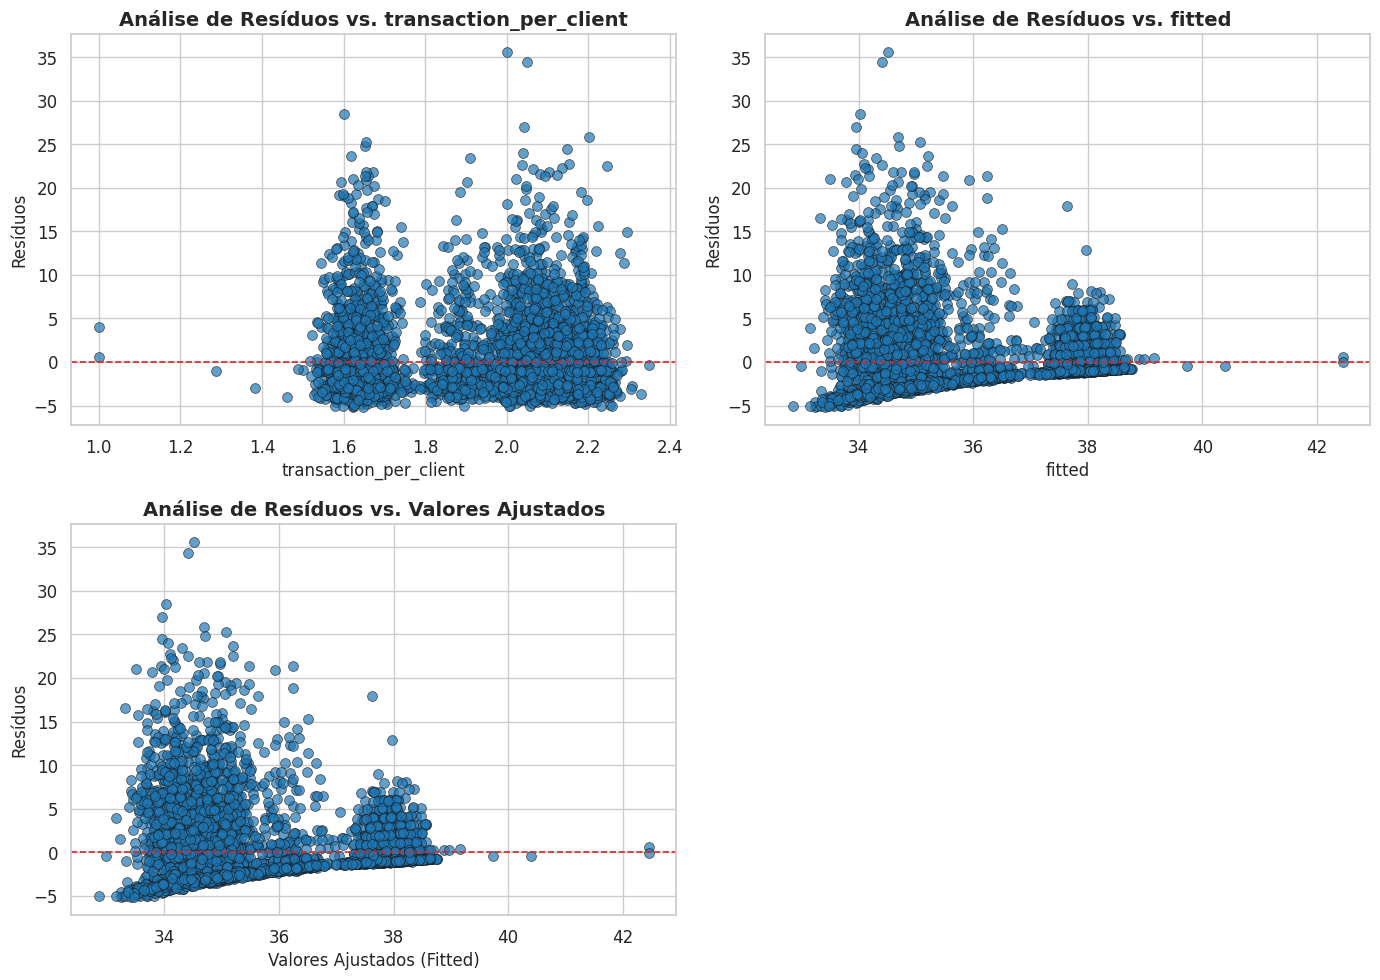

In [95]:
# Estilo mais profissional e consistente
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

# Paleta de cores
point_color = "#1f77b4"  # azul elegante
line_color = "#d62728"   # vermelho para linha horizontal

# Seleciona colunas para análise
cols_plot = [c for c in df_features.columns if c.lower() not in ['intercept', 'const', 'residuos']]

# Número total de gráficos
n_plots = len(cols_plot) + 1  # +1 para incluir o de valores ajustados
n_rows = (n_plots + 1) // 2   # duas colunas

# Cria figura e eixos
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))
axes = axes.flatten()

# 1) Resíduos vs. variáveis explicativas
for i, col in enumerate(cols_plot):
    sns.scatterplot(data=df_features, x=col, y='residuos',
                    s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[i])
    axes[i].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
    axes[i].set_title(f"Análise de Resíduos vs. {col}", fontsize=14, weight="bold")
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Resíduos", fontsize=12)

# 2) Resíduos vs. Valores Ajustados
idx = len(cols_plot)
sns.scatterplot(x=df_features['fitted'], y=df_features['residuos'],
                s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[idx])
axes[idx].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
axes[idx].set_title("Análise de Resíduos vs. Valores Ajustados", fontsize=14, weight="bold")
axes[idx].set_xlabel("Valores Ajustados (Fitted)", fontsize=12)
axes[idx].set_ylabel("Resíduos", fontsize=12)

# Remove eixos extras se sobrar espaço
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [96]:
validar_autocorrelacao_ljung_box(best_model.resid)


--- Resultados do Teste de Ljung-Box ---
        lb_stat  lb_pvalue
20  5144.166255        0.0

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).
Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.

Resultado: O p-valor (0.0000) é MENOR que 0.05.
Decisão: Rejeitamos a Hipótese Nula (H₀).
✅ Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.


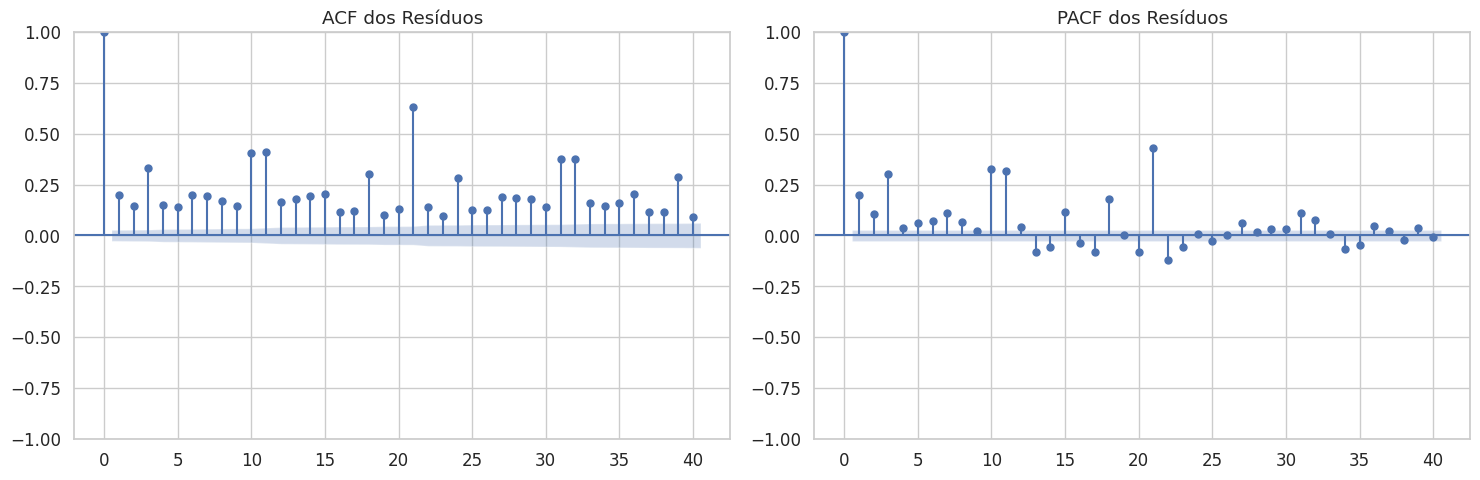

In [99]:
plot_acf_pacf(best_model.resid, 40)